# 1. Advanced LSTM (Full Dataset)

## 1.1 Import of packages, dataset and decision point map

In [5]:
# --- Standard Library ---
import os
import sys
import importlib
import re


# --- Third-Party Packages ---
import joblib
import numpy as np
import pandas as pd
from pathlib import Path

# ── Data & Visualization ─────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PM4Py (BPMN handling)
from pm4py.objects.bpmn.importer import importer as bpmn_importer
from pm4py.objects.conversion.bpmn.variants import to_petri_net

# --- TensorFlow / Keras ---
from tensorflow.keras.optimizers import Adam

# --- Scikit-learn ---
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder

# --- Project Utilities ---
# Add FINAL/code to sys.path to import custom functions
code_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "code"))
sys.path.insert(0, code_dir)

from preprocess import extract_bpmn_decision_point_map

from train import (
    prepare_sequences_and_labels,
    prepare_context_attributes,
    build_lstm_model_advanced,
    train_model_advanced,
    tune_hyperparameters_for_dp
)
from evaluate import (
    evaluate_baseline,
    compare_f1_for_trained_model,
    add_unknown_label,
    permutation_importance_context,
    permutation_importance_all_features,
    plot_feature_importance
)

In [6]:
# Import BPMN-File
bpmn_model = bpmn_importer.apply("../resources/loan_application.bpmn")

# Convert BPMN to Petri net
net, im, fm = to_petri_net.apply(bpmn_model)

bpmn_decision_point_map = extract_bpmn_decision_point_map(bpmn_model)

In [7]:
# Path relative to current working directory
path = "../data/processed/dp_split_datasets_full_advanced.joblib"

dp_split_datasets_full_advanced = joblib.load(path)

print("Loaded type:", type(dp_split_datasets_full_advanced))
print("Top-level keys:", list(dp_split_datasets_full_advanced.keys())[:5])

Loaded type: <class 'dict'>
Top-level keys: ['DP 1', 'DP 3', 'DP 4', 'DP 5', 'DP 7']


## 1.2 Training for each decision point and prediction Test-Set

In [ ]:
# --- Storage ---
accuracy_per_class = []
baseline_accuracy_per_class = []
decision_point_models_advanced = {}

# --- Parameters ---
context_keys_advanced = [
    "case:LoanGoal",
    "case:ApplicationType",
    "case:RequestedAmount",
    "position_in_trace",
    "day_of_week",
    "time_of_day",
    "month",
    "week_of_year",
    "is_weekend",
    "is_holiday_nl",
    "time_since_case_start",
    "time_since_prev_event",
    "n_repeats_current_activity",
    "n_unique_activities",
    "immediate_loop",
    "n_total_repeats",
    "longest_repeat_streak"
]

for decision_point in bpmn_decision_point_map:
    print(f"\n=== [ADVANCED LSTM] Training {decision_point} ===")

    try:
        splits = dp_split_datasets_full_advanced.get(decision_point)
        if not splits:
            print(f"No split data for {decision_point}")
            continue

        df_train = splits["train"]
        df_test = splits["test"]
        df_combined = pd.concat([df_train, df_test], ignore_index=True)

        # --- Prepare sequences ---
        X_acts_padded, X_durs_padded, X_res_padded, activity_encoder, resource_encoder, label_encoder, y_all, max_seq_len = prepare_sequences_and_labels(df_combined)

        # Add "UNKNOWN" to encoders if missing
        if "UNKNOWN" not in resource_encoder.classes_:
            resource_encoder.classes_ = np.append(resource_encoder.classes_, "UNKNOWN")
        if "UNKNOWN" not in activity_encoder.classes_:
            activity_encoder.classes_ = np.append(activity_encoder.classes_, "UNKNOWN")

        # --- Prepare context features ---
        X_context_array, context_dim, context_encoders = prepare_context_attributes(df_combined, context_keys_advanced)

        # --- Train/Test split indices ---
        train_idx = df_train.index.tolist()
        test_idx = df_test.index.tolist()

        X_train = [X_acts_padded[train_idx], X_durs_padded[train_idx], X_res_padded[train_idx], X_context_array[train_idx]]
        y_train = y_all[train_idx]

        X_test = [X_acts_padded[test_idx], X_durs_padded[test_idx], X_res_padded[test_idx], X_context_array[test_idx]]
        y_test = y_all[test_idx]

        # --- Build model ---
        model = build_lstm_model_advanced(
            num_activities=len(activity_encoder.classes_),
            num_resources=len(resource_encoder.classes_),
            context_dim=context_dim,
            max_seq_len=max_seq_len,
            num_classes=len(label_encoder.classes_)
        )

        # --- Train model ---
        model = train_model_advanced(
            model=model,
            X_train=X_train,
            y_train=y_train,
            label_encoder=label_encoder
        )

        # --- Predict and evaluate ---
        y_pred_probs = model.predict(X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)


        lstm_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True, zero_division=0)
        baseline_report = evaluate_baseline(y_test, label_encoder)  # If using dist baseline now

        print(f"\n--- [ADVANCED LSTM] Results for {decision_point} ---")
        for label in label_encoder.classes_:
            if label in lstm_report:
                print(f"{label}: Precision={lstm_report[label]['precision']:.2f}, Recall={lstm_report[label]['recall']:.2f}, F1={lstm_report[label]['f1-score']:.2f}")

        # --- Store per-class results ---
        for label in label_encoder.classes_:
            if label in lstm_report:
                accuracy_per_class.append({
                    "decision_point": decision_point,
                    "label": label,
                    "precision": round(lstm_report[label]["precision"] * 100, 2),
                    "recall": round(lstm_report[label]["recall"] * 100, 2),
                    "f1_score": round(lstm_report[label]["f1-score"] * 100, 2),
                    "support": lstm_report[label]["support"]
                })
            if label in baseline_report:
                baseline_accuracy_per_class.append({
                    "decision_point": decision_point,
                    "label": label,
                    "precision": round(baseline_report[label]["precision"] * 100, 2),
                    "recall": round(baseline_report[label]["recall"] * 100, 2),
                    "f1_score": round(baseline_report[label]["f1-score"] * 100, 2),
                    "support": baseline_report[label]["support"]
                })

        # --- Save model and encoders ---
        decision_point_models_advanced[decision_point] = {
            "model": model,
            "activity_encoder": activity_encoder,
            "resource_encoder": resource_encoder,
            "label_encoder": label_encoder,
            "context_keys": context_keys_advanced,
            "context_encoders": context_encoders,
            "max_seq_len": max_seq_len
        }

    except Exception as e:
        print(f"Error while training {decision_point}: {e}")


=== [ADVANCED LSTM] Training DP 1 ===
Epoch 1/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7263 - loss: 0.8169 - val_accuracy: 0.9973 - val_loss: 0.0617
Epoch 2/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9763 - loss: 0.1259 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0222 - val_accuracy: 1.0000 - val_loss: 5.5540e-04
Epoch 4/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0067 - val_accuracy: 1.0000 - val_loss: 3.5956e-04
Epoch 5/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0045 - val_accuracy: 1.0000 - val_loss: 2.1215e-04
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step

--- [ADVANCED LSTM] Results for DP 1 ---
A_Concept: Precision=1.00, Recall=1.00, F1=1.00
A_Submitted: Precision=1.00, Recall=1.00, F1=1.00
W_Complete application: Precision=1.00, Rec

In [9]:
# Convert results to DataFrames
df_accuracy = pd.DataFrame(accuracy_per_class)
df_baseline = pd.DataFrame(baseline_accuracy_per_class)

# Calculate total support per decision point (for per-DP percentage if needed)
total_support_per_dp = df_accuracy.groupby("decision_point")["support"].transform("sum")
df_accuracy["support_percentage"] = round(df_accuracy["support"] / total_support_per_dp * 100, 2)

# --- Overall Weighted Metrics ---
weighted_precision_lstm = (df_accuracy["precision"] * df_accuracy["support"]).sum() / df_accuracy["support"].sum()
weighted_recall_lstm = (df_accuracy["recall"] * df_accuracy["support"]).sum() / df_accuracy["support"].sum()
weighted_f1_lstm = (df_accuracy["f1_score"] * df_accuracy["support"]).sum() / df_accuracy["support"].sum()

weighted_precision_majority = (df_baseline["precision"] * df_baseline["support"]).sum() / df_baseline["support"].sum()
weighted_recall_majority = (df_baseline["recall"] * df_baseline["support"]).sum() / df_baseline["support"].sum()
weighted_f1_majority = (df_baseline["f1_score"] * df_baseline["support"]).sum() / df_baseline["support"].sum()

# Relative improvements
relative_improvement_f1 = (weighted_f1_lstm - weighted_f1_majority) / weighted_f1_majority * 100
relative_improvement_precision = (weighted_precision_lstm - weighted_precision_majority) / weighted_precision_majority * 100
relative_improvement_recall = (weighted_recall_lstm - weighted_recall_majority) / weighted_recall_majority * 100

# --- Print Global Comparison ---
print("\n=== Global Comparison Across All Decision Points ===")
print(f"Weighted Precision (LSTM):     {weighted_precision_lstm:.3f}")
print(f"Weighted Precision (Majority): {weighted_precision_majority:.3f}")
print(f"Relative Improvement:          {relative_improvement_precision:.2f}%\n")

print(f"Weighted Recall (LSTM):        {weighted_recall_lstm:.3f}")
print(f"Weighted Recall (Majority):    {weighted_recall_majority:.3f}")
print(f"Relative Improvement:          {relative_improvement_recall:.2f}%\n")

print(f"Weighted F1 (LSTM):            {weighted_f1_lstm:.3f}")
print(f"Weighted F1 (Majority):        {weighted_f1_majority:.3f}")
print(f"Relative Improvement:          {relative_improvement_f1:.2f}%")


=== Global Comparison Across All Decision Points ===
Weighted Precision (LSTM):     89.560
Weighted Precision (Majority): 40.554
Relative Improvement:          120.84%

Weighted Recall (LSTM):        71.966
Weighted Recall (Majority):    40.574
Relative Improvement:          77.37%

Weighted F1 (LSTM):            77.435
Weighted F1 (Majority):        40.562
Relative Improvement:          90.90%


## 1.3 Hyperparameter-Tuning for Low-Performing Models

In [10]:
# Compute weighted F1-score per decision point without including the grouping column
dp_weighted_f1 = (
    df_accuracy
    .groupby("decision_point")
    .apply(lambda g: (g["f1_score"] * g["support"]).sum() / g["support"].sum(), include_groups=False)
    .reset_index(name="weighted_f1")
)

# Filter decision points below 80%
underperforming_dps = dp_weighted_f1[dp_weighted_f1["weighted_f1"] < 85]
low_accuracy_dps = underperforming_dps["decision_point"].tolist()

print("Decision Points with Weighted F1-score < 85%:\n")
print(underperforming_dps)
print(len(underperforming_dps))

Decision Points with Weighted F1-score < 85%:

   decision_point  weighted_f1
1           DP 10    79.642055
2           DP 11    77.797133
3           DP 12    77.277733
9           DP 19    76.474490
10          DP 20    82.221280
11          DP 21    70.731426
12          DP 22    70.421174
14          DP 25    83.548007
16          DP 27    76.556329
17          DP 28    77.339265
18          DP 29    78.133805
20          DP 30    77.551032
21          DP 31    58.202422
22          DP 32    77.426666
24          DP 34    76.806458
25          DP 35    77.096858
26          DP 36    75.480939
27          DP 37    77.056654
28          DP 39    60.068305
30          DP 40    75.746265
31          DP 41    61.925318
32          DP 42    78.345506
33          DP 43    77.569832
34          DP 44    80.427241
35          DP 46    83.634406
37          DP 48    78.434354
38          DP 49    78.583274
40           DP 7    61.552694
41           DP 8    72.981530
42           DP 9    78

In [8]:
# Store tuned models and their performance
tuned_models = {}

for dp in low_accuracy_dps:
    print(f"\nTuning Decision Point: {dp}")
    
    splits = dp_split_datasets_full_advanced.get(dp)
    if not splits:
        print(f"No data available for {dp}")
        continue

    # Combine train and test data for preprocessing
    df_train = splits["train"]
    df_test = splits["test"]
    df_combined = pd.concat([df_train, df_test], ignore_index=True)

    try:
        # Perform hyperparameter tuning
        best_hp, best_model, label_enc = tune_hyperparameters_for_dp(
            dp_name=dp,
            df=df_combined,
            context_keys=context_keys_advanced,
            max_trials=5,  # Adjust as needed
            executions_per_trial=1,
            target_val_acc=0.9
        )

        # Save the best model and encoder
        tuned_models[dp] = {
            "model": best_model,
            "hyperparameters": best_hp,
            "label_encoder": label_enc
        }

    except Exception as e:
        print(f"Error while tuning {dp}: {e}")

Trial 5 Complete [00h 02m 37s]
val_accuracy: 0.8737452030181885

Best val_accuracy So Far: 0.8817077875137329
Total elapsed time: 00h 12m 45s


/Users/marcohmayer/.pyenv/versions/3.11.8/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [9]:
# Step 1: Compute weighted F1-scores per decision point
dp_weighted_f1 = (
    df_accuracy
    .groupby("decision_point")
    .apply(lambda g: (g["f1_score"] * g["support"]).sum() / g["support"].sum(), include_groups=False)
    .reset_index(name="weighted_f1")
)

# Convert to dict for fast lookup
dp_f1_dict = dp_weighted_f1.set_index("decision_point")["weighted_f1"].to_dict()

# Step 2: Loop over all DPs and build rows
dp_rows = []
all_decision_points = list(bpmn_decision_point_map.keys())

for dp_name in all_decision_points:
    # Tuned model
    if dp_name in tuned_models:
        model = tuned_models[dp_name]["model"]
        hp = tuned_models[dp_name]["hyperparameters"]
        acc = tuned_models[dp_name].get("final_training_accuracy", None)

        row = {
            "decision_point": dp_name,
            "embedding_dim": hp.get("embedding_dim"),
            "lstm_units": hp.get("lstm_units"),
            "dropout_rate": hp.get("dropout_rate"),
            "learning_rate": round(hp.get("learning_rate"), 6),
        }

    # Non-tuned model → use defaults and fallback to F1
    else:
        fallback_acc = dp_f1_dict.get(dp_name, None)
        row = {
            "decision_point": dp_name,
            "embedding_dim": 64,
            "lstm_units": 128,
            "dropout_rate": 0.3,
            "learning_rate": 0.001,
        }

    dp_rows.append(row)

# Step 3: Create summary DataFrame
df_hyperparams_summary = pd.DataFrame(dp_rows)
df_hyperparams_summary.set_index("decision_point", inplace=True)
df_hyperparams_summary = df_hyperparams_summary.sort_index()
display(df_hyperparams_summary)

,embedding_dim,lstm_units,dropout_rate,learning_rate
decision_point,,,,
DP 1,64,128,0.3,0.001000
DP 10,64,128,0.2,0.001294
DP 11,128,256,0.4,0.001326
DP 12,32,64,0.4,0.003402
DP 13,64,128,0.3,0.001000
DP 14,64,128,0.3,0.001000
DP 15,64,128,0.3,0.001000
DP 16,64,128,0.3,0.001000
DP 17,64,128,0.3,0.001000


In [12]:
from io import StringIO

raw = """
	embedding_dim	lstm_units	dropout_rate	learning_rate
decision_point				
DP 1	64	128	0.3	0.001000
DP 10	64	128	0.2	0.001294
DP 11	128	256	0.4	0.001326
DP 12	32	64	0.4	0.003402
DP 13	64	128	0.3	0.001000
DP 14	64	128	0.3	0.001000
DP 15	64	128	0.3	0.001000
DP 16	64	128	0.3	0.001000
DP 17	64	128	0.3	0.001000
DP 18	64	128	0.3	0.001000
DP 19	128	64	0.3	0.000578
DP 2	64	128	0.3	0.001000
DP 20	128	128	0.2	0.000826
DP 21	32	128	0.3	0.001694
DP 22	128	256	0.3	0.003610
DP 23	64	128	0.3	0.001000
DP 24	64	128	0.3	0.001000
DP 25	128	256	0.3	0.005407
DP 26	64	128	0.3	0.001000
DP 27	64	64	0.2	0.004275
DP 28	64	64	0.2	0.000955
DP 29	64	128	0.2	0.000615
DP 3	64	128	0.3	0.001000
DP 30	32	128	0.3	0.001232
DP 31	128	128	0.2	0.003920
DP 32	128	128	0.3	0.001712
DP 33	64	128	0.3	0.001000
DP 34	32	128	0.4	0.000381
DP 35	64	64	0.2	0.001043
DP 36	128	64	0.3	0.000479
DP 37	128	256	0.3	0.000279
DP 38	64	128	0.3	0.001000
DP 39	32	256	0.3	0.001809
DP 4	64	128	0.3	0.001000
DP 40	64	128	0.4	0.000203
DP 41	128	256	0.2	0.000163
DP 42	128	256	0.2	0.002510
DP 43	128	128	0.2	0.001769
DP 44	64	128	0.3	0.001319
DP 45	64	128	0.3	0.001000
DP 46	64	128	0.3	0.001326
DP 47	64	128	0.3	0.001000
DP 48	64	256	0.4	0.000195
DP 49	128	128	0.2	0.001114
DP 5	64	128	0.3	0.001000
DP 6	64	128	0.3	0.001000
DP 7	128	256	0.3	0.001570
DP 8	32	128	0.3	0.001619
DP 9	64	64	0.2	0.000817
"""

lines = [ln for ln in raw.strip().splitlines() if ln.strip()]
# header line
hdr_line = next(ln for ln in lines if "embedding_dim" in ln)
cols = ["decision_point"] + re.split(r"\s+", hdr_line.strip())
# data lines (skip header and the lone 'decision_point' line)
start = lines.index(hdr_line) + 1
rows = []
for ln in lines[start:]:
    if ln.strip() == "decision_point":
        continue
    parts = re.split(r"\s+", ln.strip())
    dp = " ".join(parts[:2])           # e.g., "DP 12"
    emb, lstm, dr, lr = parts[2:]
    rows.append([dp, int(emb), int(lstm), float(dr), float(lr)])

df_hyperparams_summary = pd.DataFrame(rows, columns=cols).set_index("decision_point")
display(df_hyperparams_summary)

,embedding_dim,lstm_units,dropout_rate,learning_rate
decision_point,,,,
DP 1,64,128,0.3,0.001000
DP 10,64,128,0.2,0.001294
DP 11,128,256,0.4,0.001326
DP 12,32,64,0.4,0.003402
DP 13,64,128,0.3,0.001000
DP 14,64,128,0.3,0.001000
DP 15,64,128,0.3,0.001000
DP 16,64,128,0.3,0.001000
DP 17,64,128,0.3,0.001000


## 1.4 Retraining and Final Prediction on Hold-Out-Set

In [16]:
# --- Storage ---
final_holdout_predictions_advanced = {}
accuracy_per_class = []
models_advanced_holdout = {}


# Loop over each decision point
for dp_name in df_hyperparams_summary.index:
    print(f"\nRetraining and predicting holdout for: {dp_name}")

    try:
        # Get data splits
        splits = dp_split_datasets_full_advanced.get(dp_name)
        if not splits or "holdout" not in splits:
            print(f"No holdout set for {dp_name}")
            continue

        # Combine training + test for training
        df_train = pd.concat([splits["train"], splits["test"]], ignore_index=True)
        df_holdout = splits["holdout"]

        # Prepare sequences
        X_acts, X_durs, X_res, act_enc, res_enc, label_encoder, y_train_all, max_seq_len = prepare_sequences_and_labels(df_train)
        X_acts_hold, X_durs_hold, X_res_hold, _, _, _, y_holdout, _ = prepare_sequences_and_labels(df_holdout)

        # Context attributes
        X_ctx_train, context_dim, _ = prepare_context_attributes(df_train, context_keys_advanced)
        X_ctx_hold, _, _ = prepare_context_attributes(df_holdout, context_keys_advanced)

        # Add "UNKNOWN" to all label encoders (if not already present)
        def ensure_unknown(encoder):
            if "UNKNOWN" not in encoder.classes_:
                encoder.classes_ = np.append(encoder.classes_, "UNKNOWN")

        ensure_unknown(act_enc)
        ensure_unknown(res_enc)
        for enc in context_encoders.values():
            if isinstance(enc, LabelEncoder):
                ensure_unknown(enc)

        # --- Model params from summary ---
        params = df_hyperparams_summary.loc[dp_name]
        embedding_dim = int(params["embedding_dim"])
        lstm_units = int(params["lstm_units"])
        dropout_rate = params["dropout_rate"]
        learning_rate = params["learning_rate"]
        num_classes = len(label_encoder.classes_)

        # Build model
        model = build_lstm_model_advanced(
            num_activities=len(act_enc.classes_),
            num_resources=len(res_enc.classes_),
            context_dim=context_dim,
            max_seq_len=max_seq_len,
            num_classes=num_classes,
            embedding_dim=embedding_dim,
            lstm_units=lstm_units,
            dropout_rate=dropout_rate
        )

        # Compile with specific learning rate
        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

        # Train
        train_model_advanced(model, [X_acts, X_durs, X_res, X_ctx_train], y_train_all)

        # Predict on holdout
        y_pred_probs = model.predict([X_acts_hold, X_durs_hold, X_res_hold, X_ctx_hold])
        y_pred = np.argmax(y_pred_probs, axis=1)

        lstm_report = classification_report(y_holdout, y_pred, target_names=label_encoder.classes_, output_dict=True, zero_division=0)
        baseline_report = evaluate_baseline(y_holdout, label_encoder)  # If using dist baseline now

        print(f"\n--- [ADVANCED LSTM] Results for {dp_name} ---")
        for label in label_encoder.classes_:
            if label in lstm_report:
                print(f"{label}: Precision={lstm_report[label]['precision']:.2f}, Recall={lstm_report[label]['recall']:.2f}, F1={lstm_report[label]['f1-score']:.2f}")

        # --- Store per-class results ---
        for label in label_encoder.classes_:
            if label in lstm_report:
                accuracy_per_class.append({
                    "decision_point": dp_name,
                    "label": label,
                    "precision": round(lstm_report[label]["precision"] * 100, 2),
                    "recall": round(lstm_report[label]["recall"] * 100, 2),
                    "f1_score": round(lstm_report[label]["f1-score"] * 100, 2),
                    "support": lstm_report[label]["support"]
                })
            if label in baseline_report:
                baseline_accuracy_per_class.append({
                    "decision_point": dp_name,
                    "label": label,
                    "precision": round(baseline_report[label]["precision"] * 100, 2),
                    "recall": round(baseline_report[label]["recall"] * 100, 2),
                    "f1_score": round(baseline_report[label]["f1-score"] * 100, 2),
                    "support": baseline_report[label]["support"]
                })

        # Store model and metadata
        models_advanced_holdout[dp_name] = {
            "model": model,
            "activity_encoder": act_enc,
            "resource_encoder": res_enc,
            "label_encoder": label_encoder,
            "context_keys": context_keys_advanced,
            "max_seq_len": max_seq_len
        }

    except Exception as e:
        print(f"Error with {dp_name}: {e}")


Retraining and predicting holdout for: DP 1
Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7730 - loss: 0.5499 - val_accuracy: 0.9926 - val_loss: 0.0608
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9782 - loss: 0.0638 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0108 - val_accuracy: 1.0000 - val_loss: 2.3766e-04
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0044 - val_accuracy: 1.0000 - val_loss: 5.6615e-05
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 4.4239e-05
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

--- [ADVANCED LSTM] Results for DP 1 ---
A_Concept: Precision=1.00, Recall=1.00, F1=1.00
A_Submitted: Precision=1.00, Recall=1.00, F1=1.00
W_Complete application: Precision=1.00, R

In [17]:
# Convert results to DataFrames
df_accuracy = pd.DataFrame(accuracy_per_class)

# Calculate total support per decision point (for per-DP percentage if needed)
total_support_per_dp = df_accuracy.groupby("decision_point")["support"].transform("sum")
df_accuracy["support_percentage"] = round(df_accuracy["support"] / total_support_per_dp * 100, 2)

# --- Overall Weighted Metrics ---
weighted_precision_lstm = (df_accuracy["precision"] * df_accuracy["support"]).sum() / df_accuracy["support"].sum()
weighted_recall_lstm = (df_accuracy["recall"] * df_accuracy["support"]).sum() / df_accuracy["support"].sum()
weighted_f1_lstm = (df_accuracy["f1_score"] * df_accuracy["support"]).sum() / df_accuracy["support"].sum()

weighted_precision_majority = (df_baseline["precision"] * df_baseline["support"]).sum() / df_baseline["support"].sum()
weighted_recall_majority = (df_baseline["recall"] * df_baseline["support"]).sum() / df_baseline["support"].sum()
weighted_f1_majority = (df_baseline["f1_score"] * df_baseline["support"]).sum() / df_baseline["support"].sum()

# Relative improvements
relative_improvement_f1 = (weighted_f1_lstm - weighted_f1_majority) / weighted_f1_majority * 100
relative_improvement_precision = (weighted_precision_lstm - weighted_precision_majority) / weighted_precision_majority * 100
relative_improvement_recall = (weighted_recall_lstm - weighted_recall_majority) / weighted_recall_majority * 100

# --- Print Global Comparison ---
print("\n=== Global Comparison Across All Decision Points ===")
print(f"Weighted Precision (LSTM):     {weighted_precision_lstm:.3f}")
print(f"Weighted Precision (Majority): {weighted_precision_majority:.3f}")
print(f"Relative Improvement:          {relative_improvement_precision:.2f}%\n")

print(f"Weighted Recall (LSTM):        {weighted_recall_lstm:.3f}")
print(f"Weighted Recall (Majority):    {weighted_recall_majority:.3f}")
print(f"Relative Improvement:          {relative_improvement_recall:.2f}%\n")

print(f"Weighted F1 (LSTM):            {weighted_f1_lstm:.3f}")
print(f"Weighted F1 (Majority):        {weighted_f1_majority:.3f}")
print(f"Relative Improvement:          {relative_improvement_f1:.2f}%")


=== Global Comparison Across All Decision Points ===
Weighted Precision (LSTM):     86.377
Weighted Precision (Majority): 40.554
Relative Improvement:          112.99%

Weighted Recall (LSTM):        88.545
Weighted Recall (Majority):    40.574
Relative Improvement:          118.23%

Weighted F1 (LSTM):            86.467
Weighted F1 (Majority):        40.562
Relative Improvement:          113.17%


## 1.5 Comparison of Majority Predictor & LSTM per Decision Point on Holdout-Set (After Tuning)

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step

Comparison for DP 1 (Holdout Set)
Weighted F1 (LSTM):     1.000
Weighted F1 (Baseline): 0.483
Relative Improvement:   106.83%


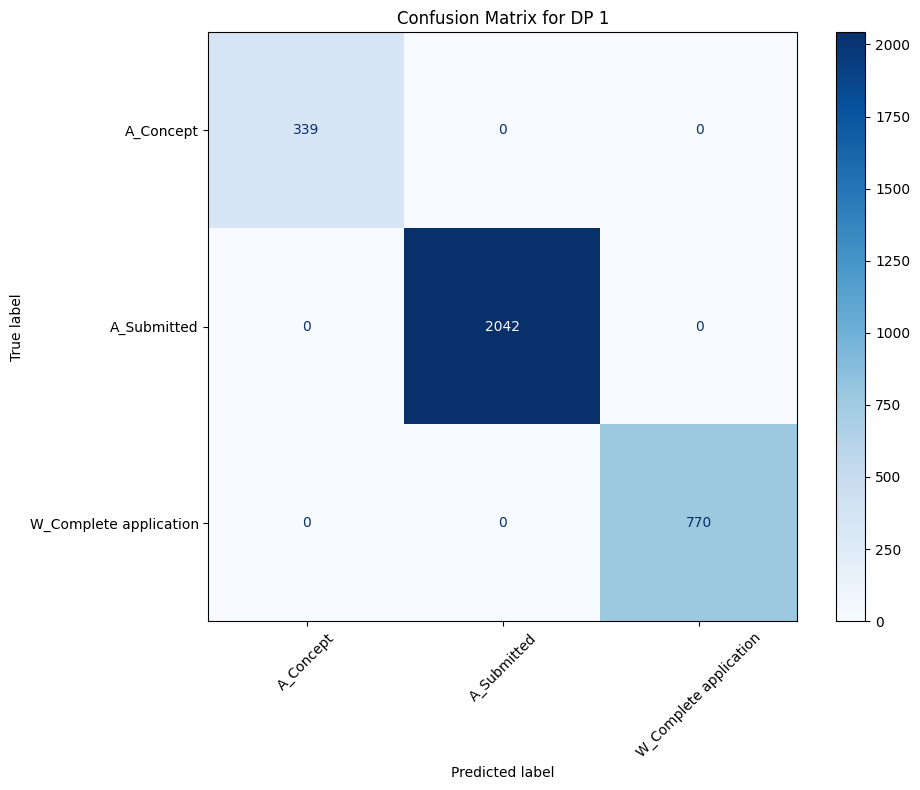

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 3 (Holdout Set)
Weighted F1 (LSTM):     0.976
Weighted F1 (Baseline): 0.511
Relative Improvement:   90.82%


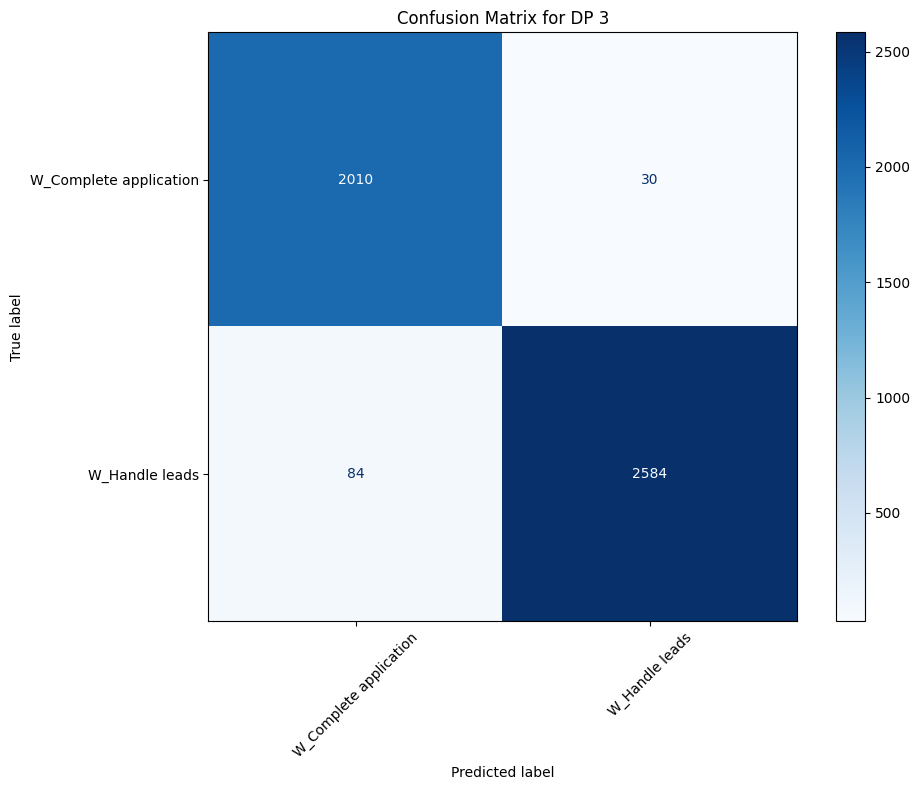

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 4 (Holdout Set)
Weighted F1 (LSTM):     1.000
Weighted F1 (Baseline): 0.809
Relative Improvement:   23.61%


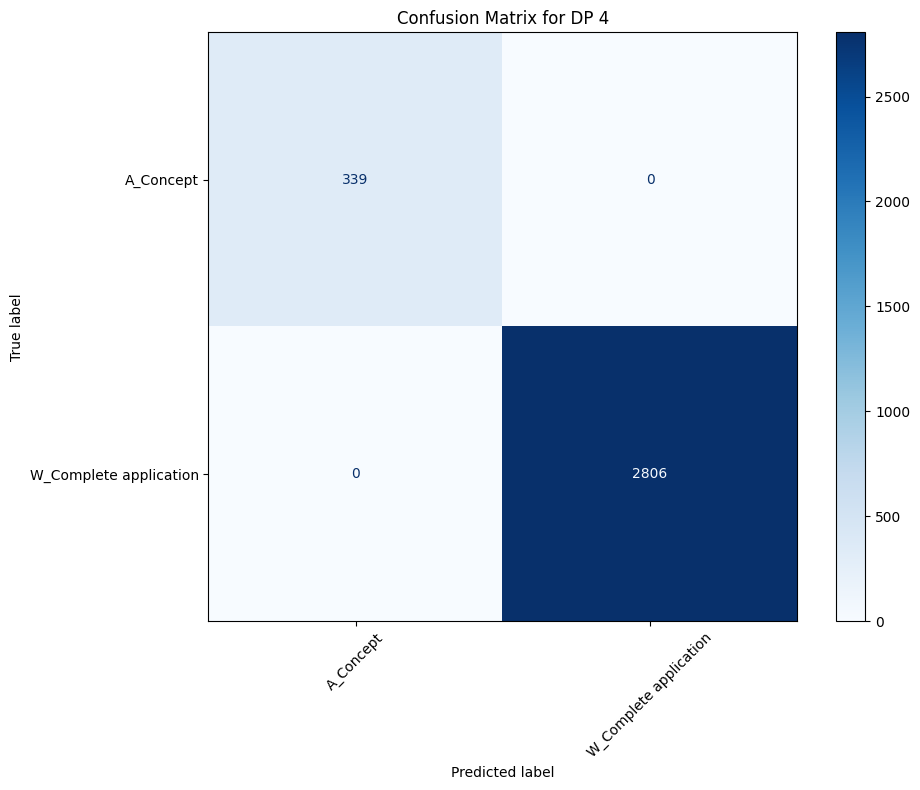

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 5 (Holdout Set)
Weighted F1 (LSTM):     1.000
Weighted F1 (Baseline): 0.809
Relative Improvement:   23.61%


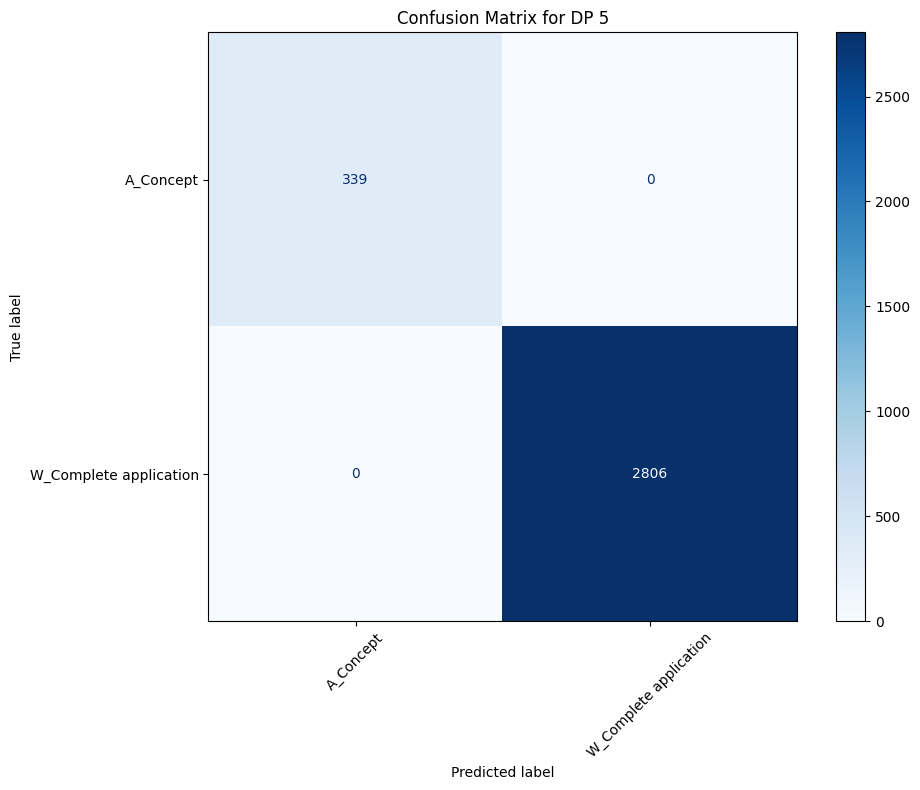

357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

Comparison for DP 7 (Holdout Set)
Weighted F1 (LSTM):     0.763
Weighted F1 (Baseline): 0.394
Relative Improvement:   93.71%


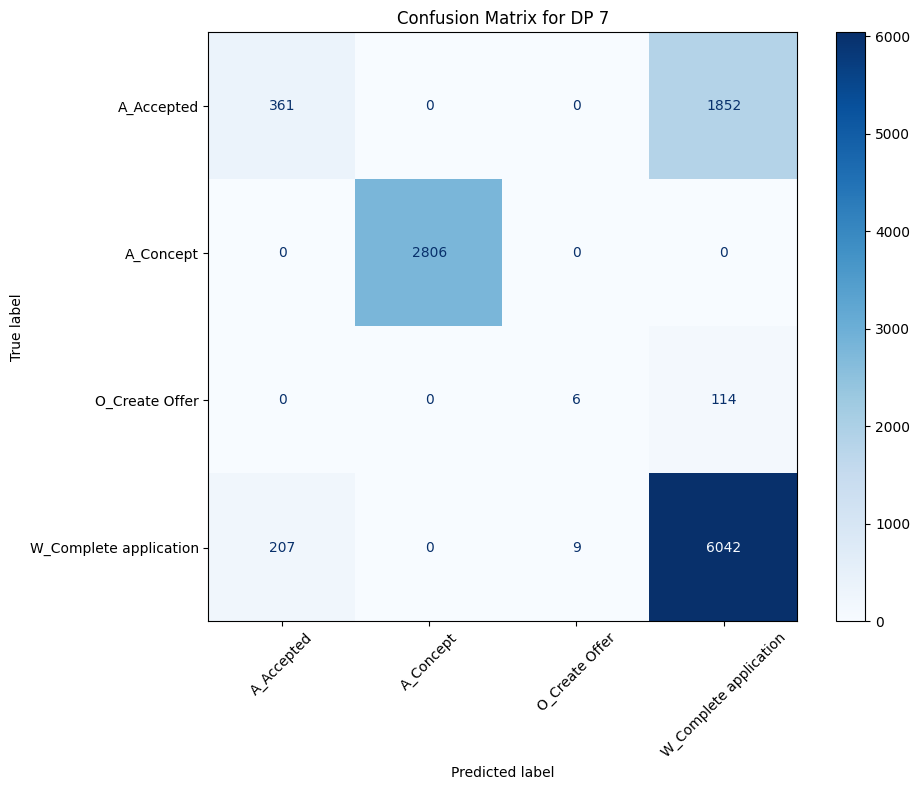

455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Comparison for DP 8 (Holdout Set)
Weighted F1 (LSTM):     0.811
Weighted F1 (Baseline): 0.454
Relative Improvement:   78.55%


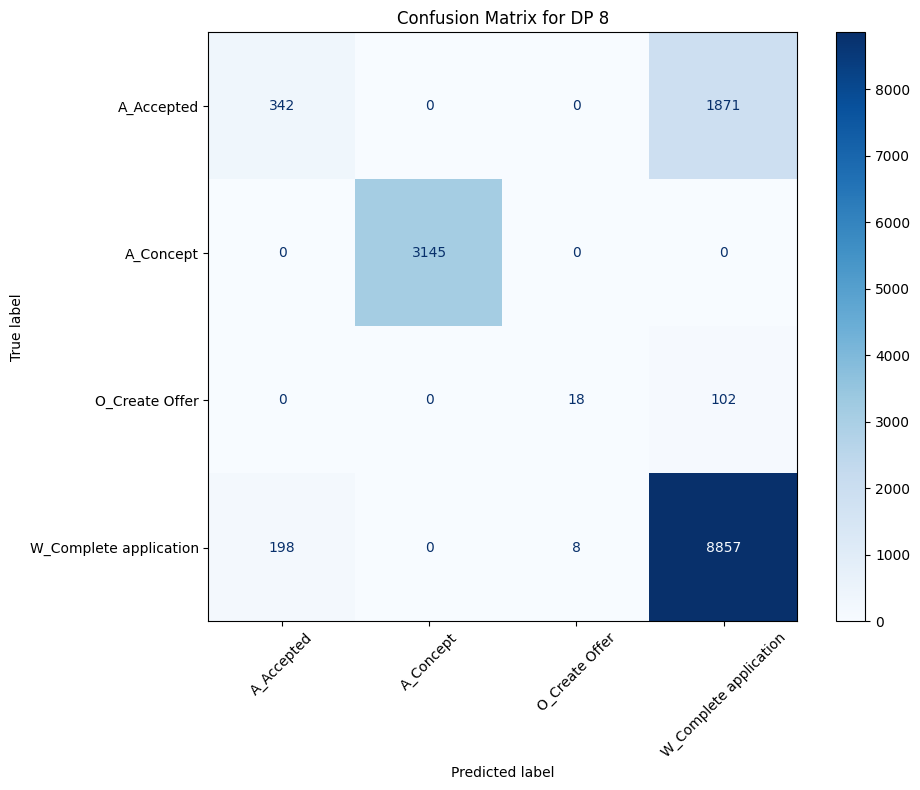

561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Comparison for DP 9 (Holdout Set)
Weighted F1 (LSTM):     0.859
Weighted F1 (Baseline): 0.494
Relative Improvement:   73.85%


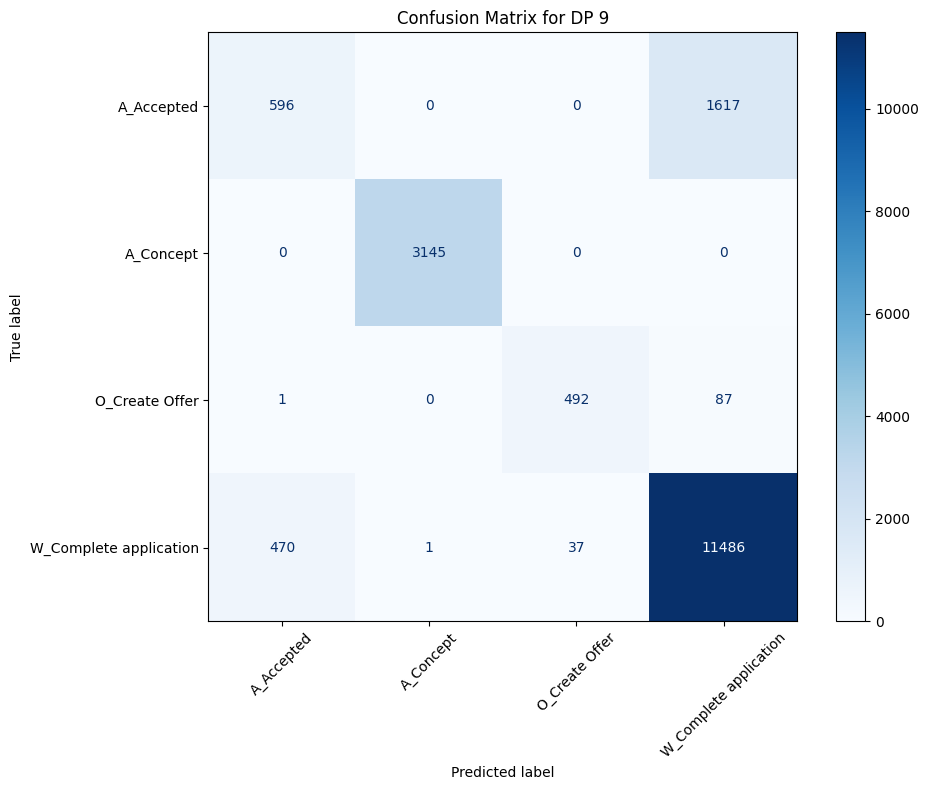

561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Comparison for DP 10 (Holdout Set)
Weighted F1 (LSTM):     0.860
Weighted F1 (Baseline): 0.494
Relative Improvement:   74.00%


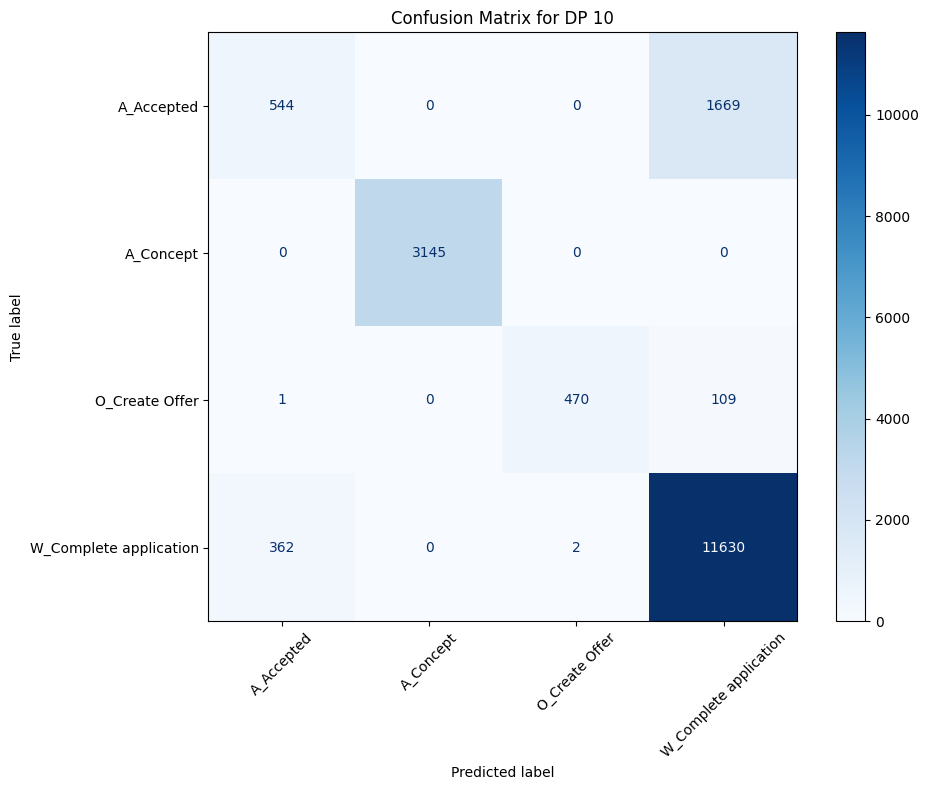

561/561 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

Comparison for DP 11 (Holdout Set)
Weighted F1 (LSTM):     0.841
Weighted F1 (Baseline): 0.658
Relative Improvement:   27.81%


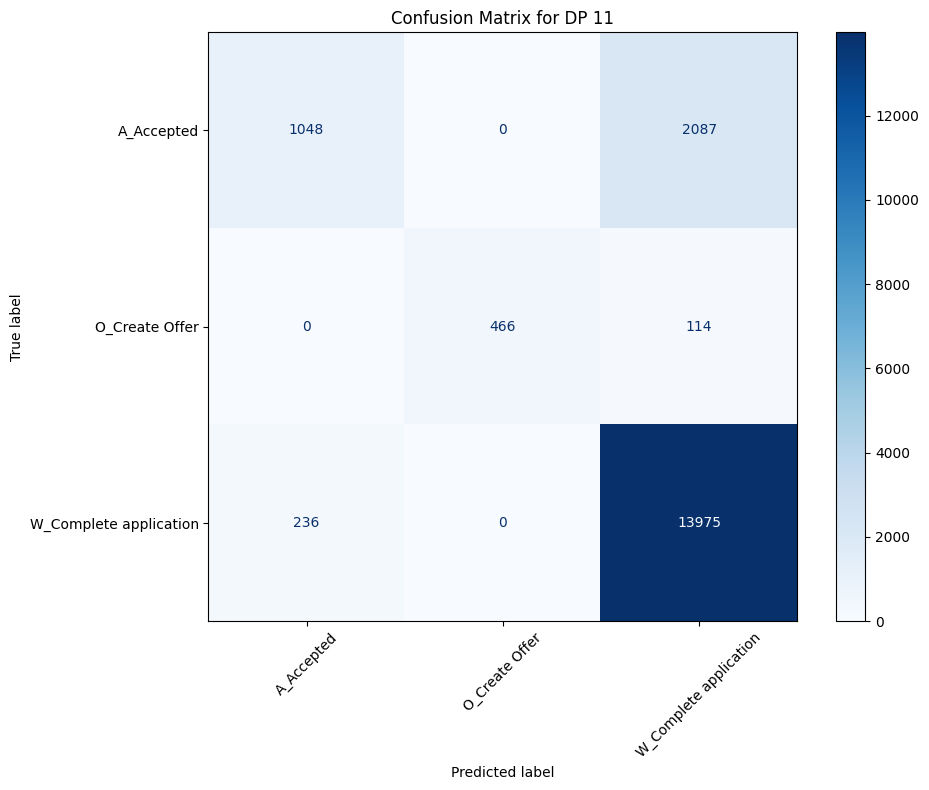

561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Comparison for DP 12 (Holdout Set)
Weighted F1 (LSTM):     0.841
Weighted F1 (Baseline): 0.658
Relative Improvement:   27.77%


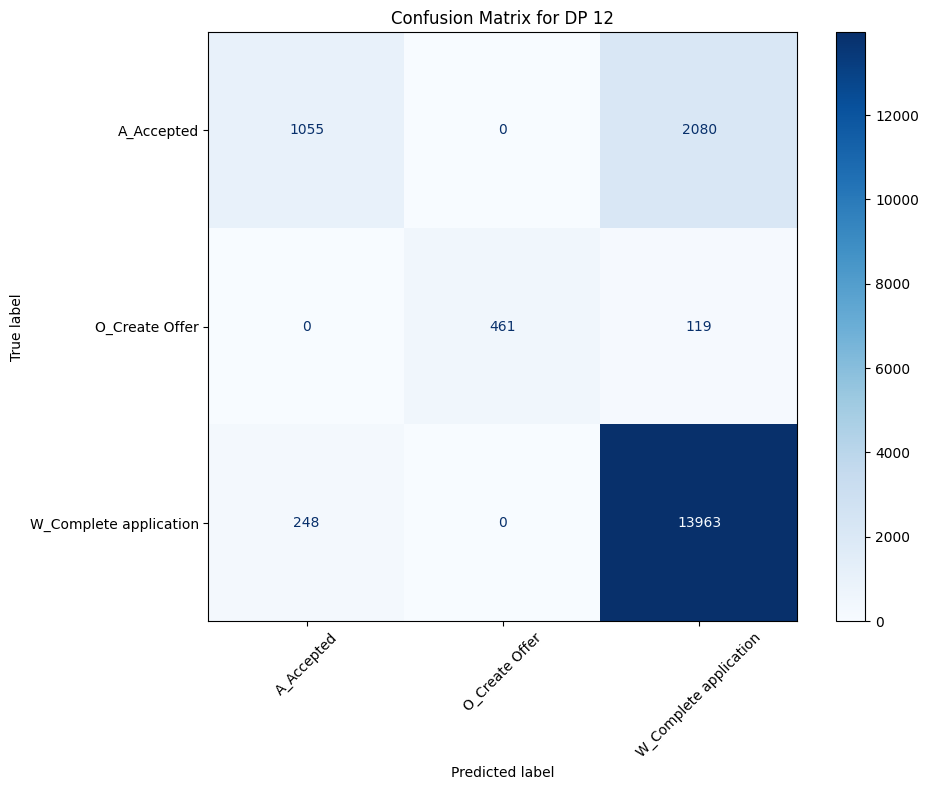

560/560 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Comparison for DP 13 (Holdout Set)
Weighted F1 (LSTM):     0.987
Weighted F1 (Baseline): 0.688
Relative Improvement:   43.59%


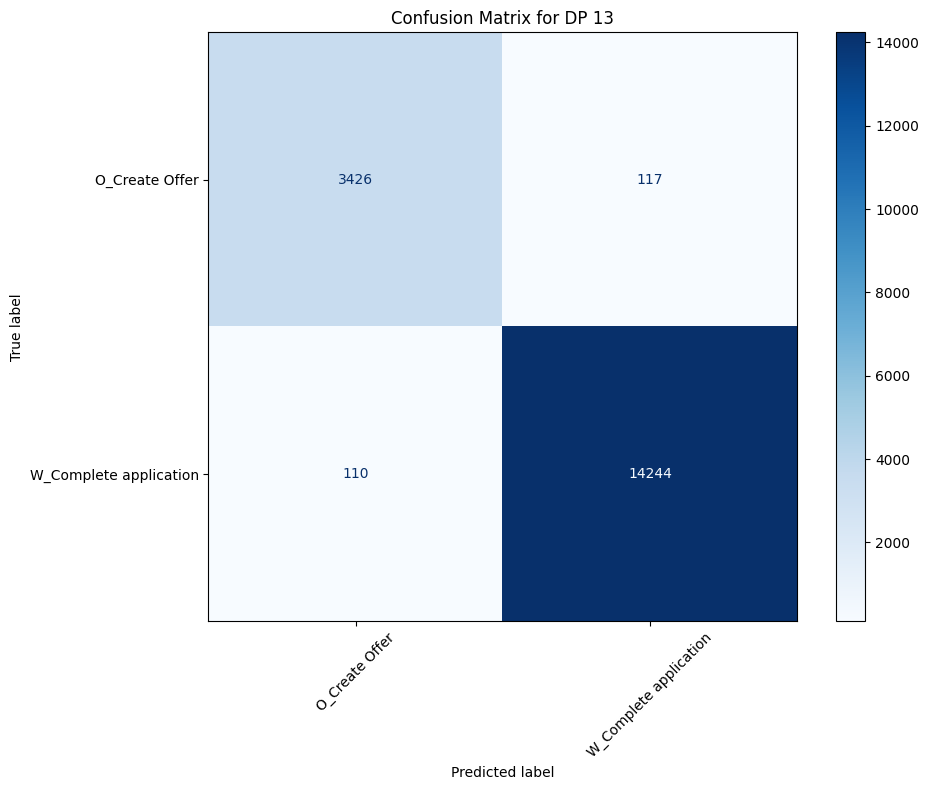

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 14 (Holdout Set)
Weighted F1 (LSTM):     0.973
Weighted F1 (Baseline): 0.930
Relative Improvement:   4.56%


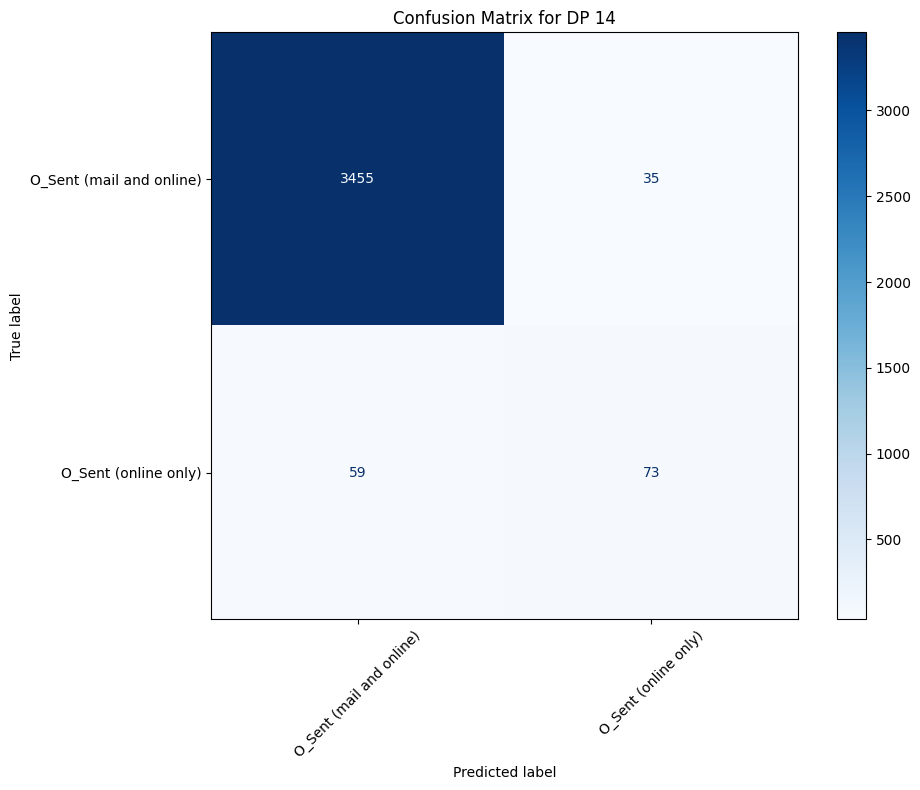

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 15 (Holdout Set)
Weighted F1 (LSTM):     0.972
Weighted F1 (Baseline): 0.930
Relative Improvement:   4.44%


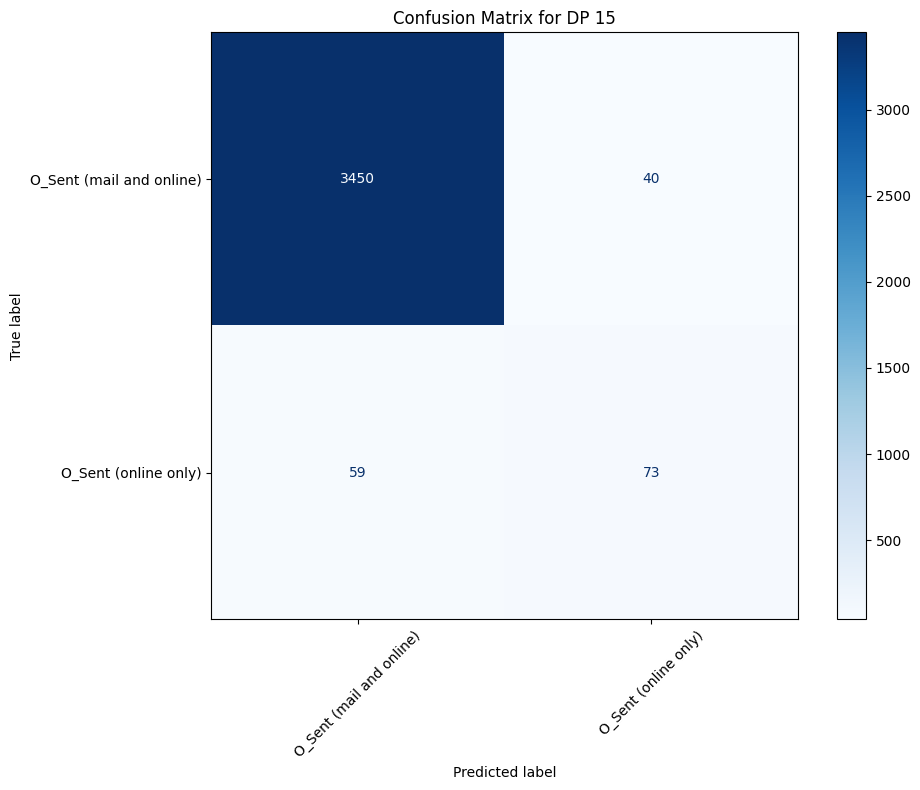

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 16 (Holdout Set)
Weighted F1 (LSTM):     0.982
Weighted F1 (Baseline): 0.796
Relative Improvement:   23.42%


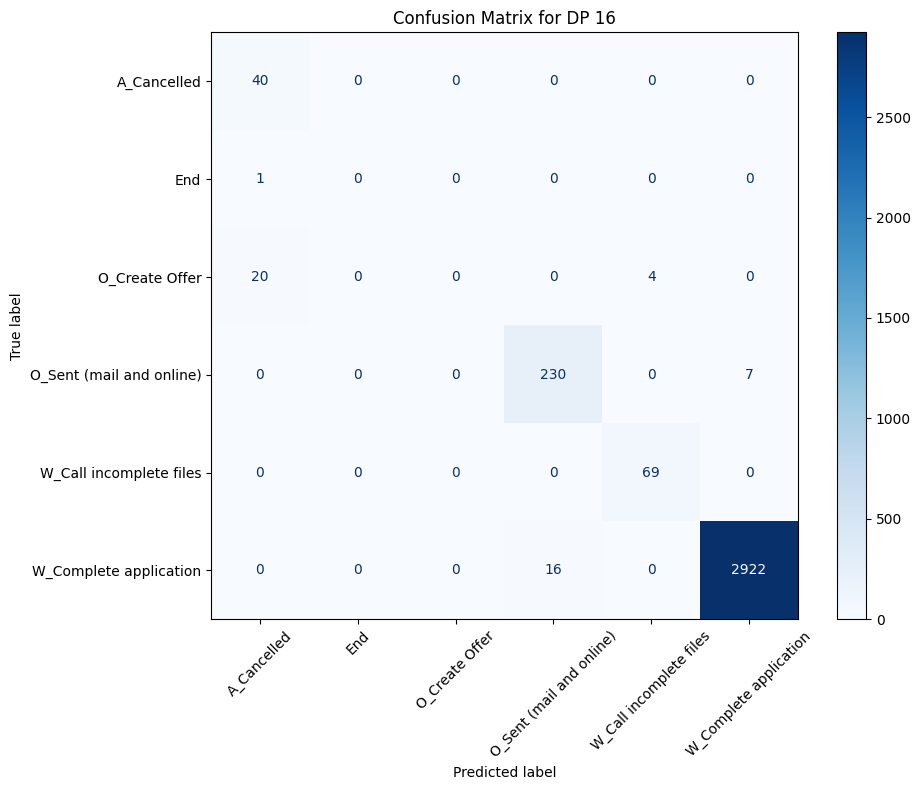

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 17 (Holdout Set)
Weighted F1 (LSTM):     0.983
Weighted F1 (Baseline): 0.796
Relative Improvement:   23.48%


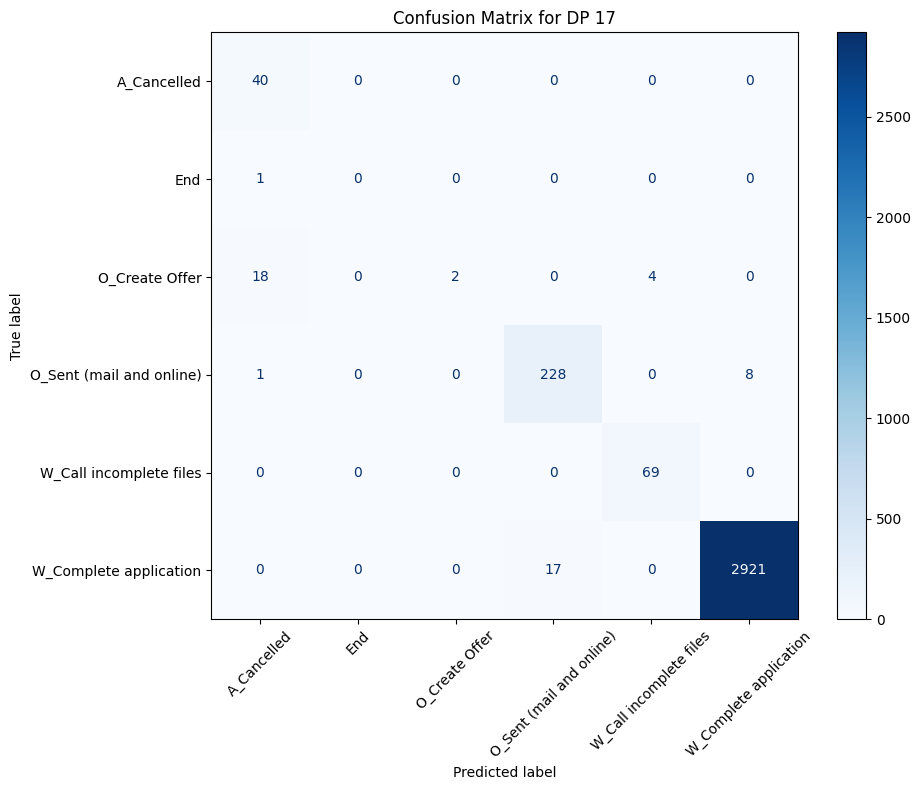

563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Comparison for DP 19 (Holdout Set)
Weighted F1 (LSTM):     0.883
Weighted F1 (Baseline): 0.414
Relative Improvement:   113.31%


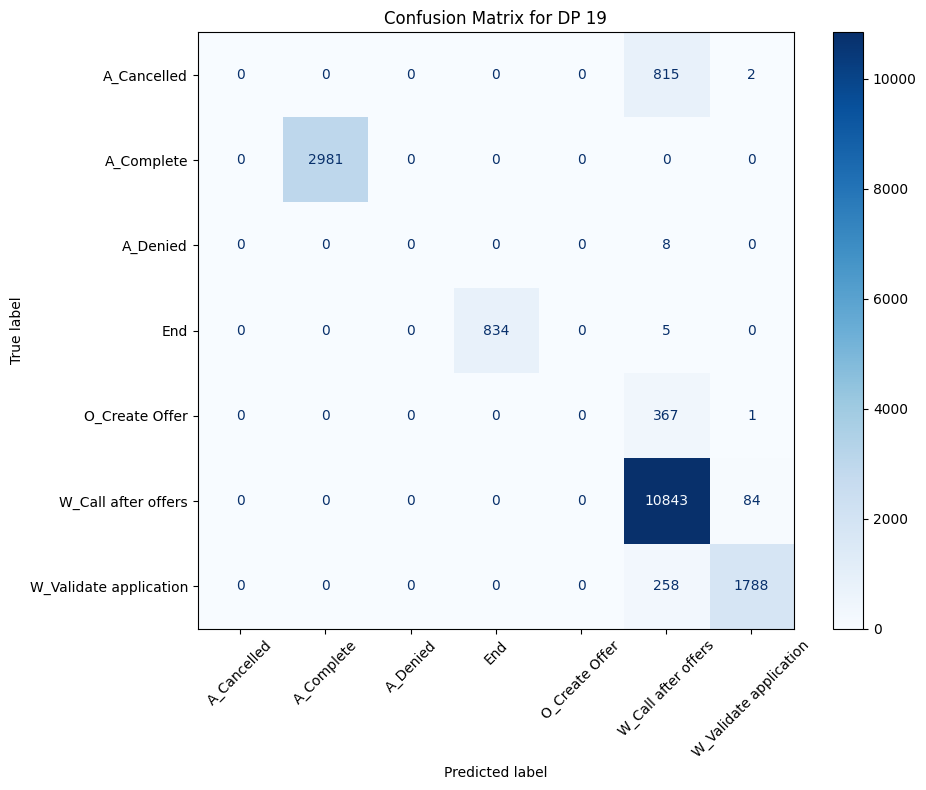

563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Comparison for DP 20 (Holdout Set)
Weighted F1 (LSTM):     0.884
Weighted F1 (Baseline): 0.414
Relative Improvement:   113.45%


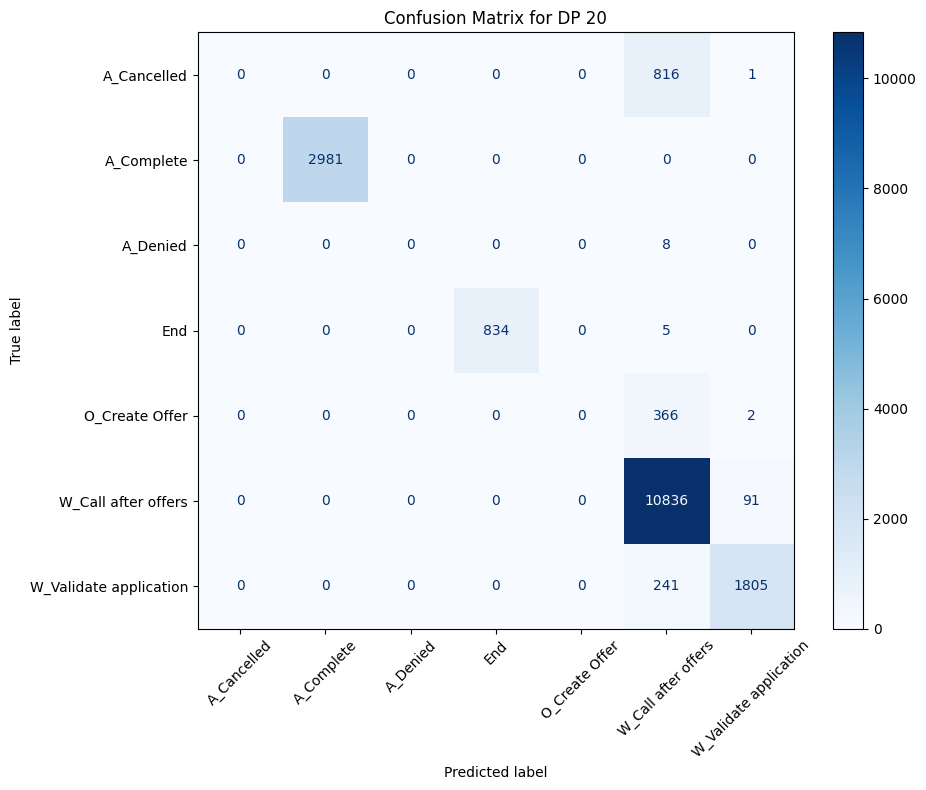

562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Comparison for DP 21 (Holdout Set)
Weighted F1 (LSTM):     0.879
Weighted F1 (Baseline): 0.607
Relative Improvement:   44.72%


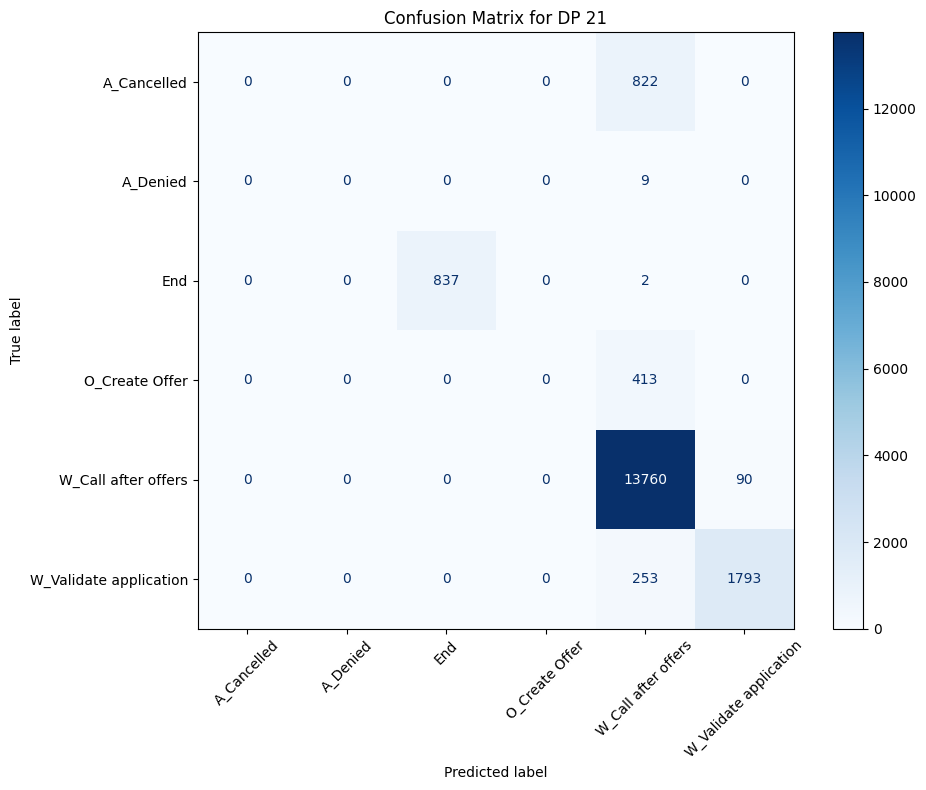

562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

Comparison for DP 22 (Holdout Set)
Weighted F1 (LSTM):     0.879
Weighted F1 (Baseline): 0.607
Relative Improvement:   44.72%


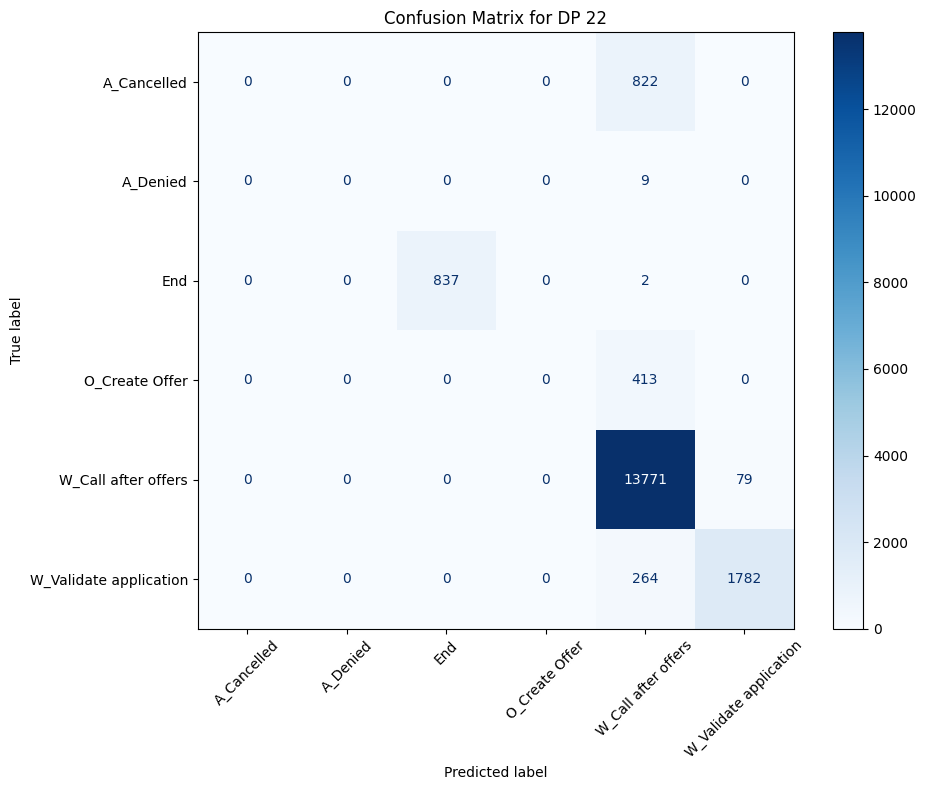

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 23 (Holdout Set)
Weighted F1 (LSTM):     0.951
Weighted F1 (Baseline): 0.278
Relative Improvement:   242.28%


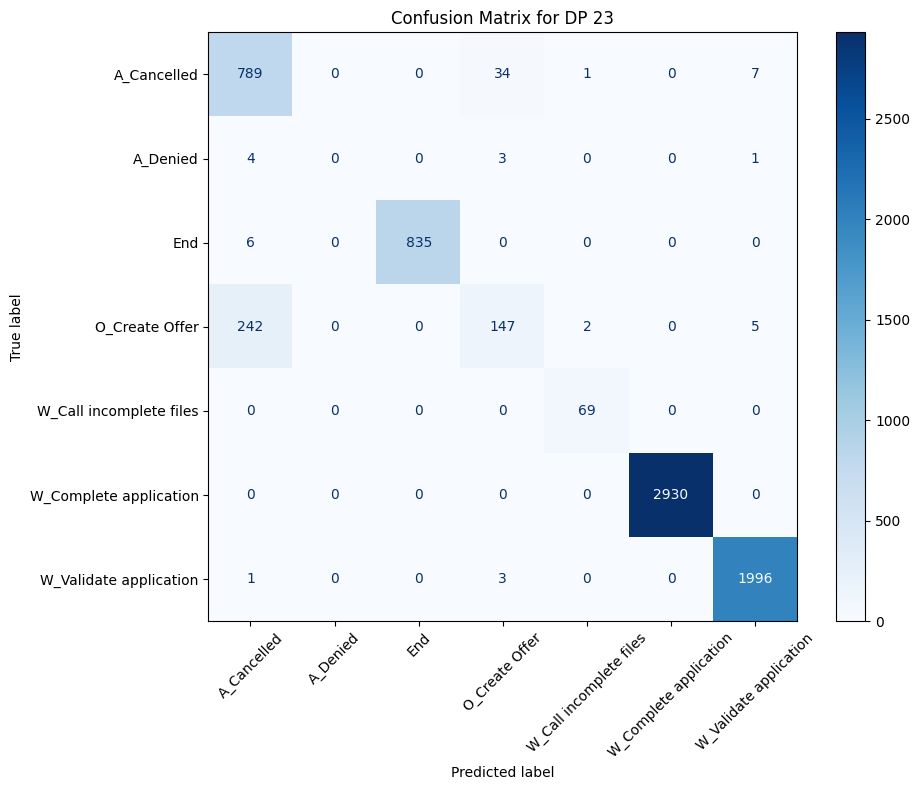

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Comparison for DP 25 (Holdout Set)
Weighted F1 (LSTM):     0.817
Weighted F1 (Baseline): 0.438
Relative Improvement:   86.74%


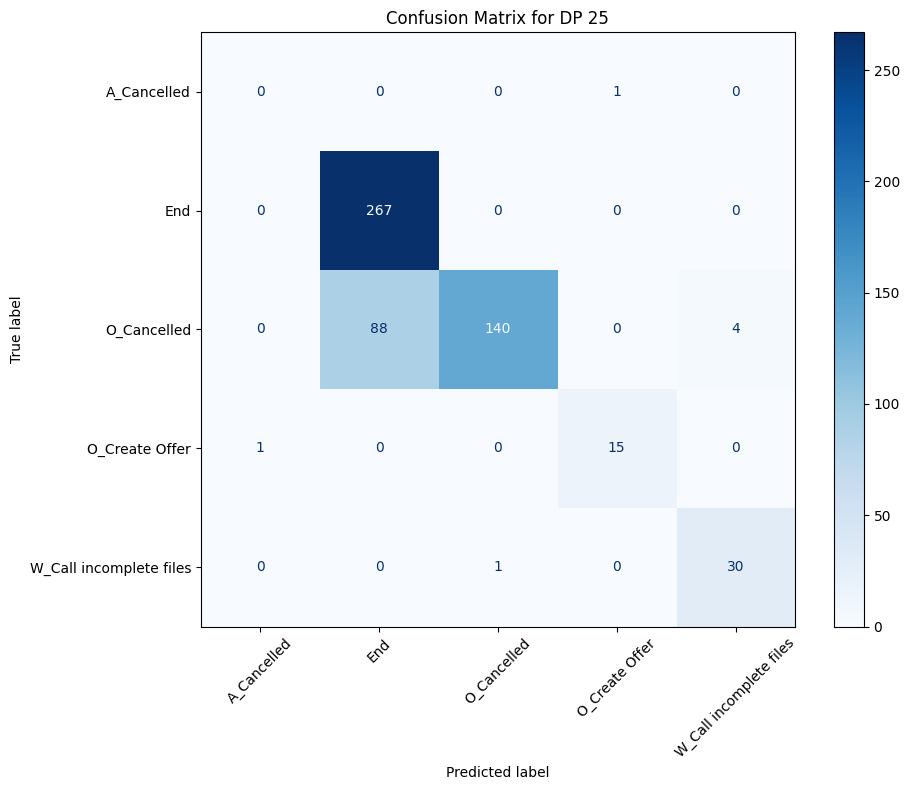

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 26 (Holdout Set)
Weighted F1 (LSTM):     0.956
Weighted F1 (Baseline): 0.270
Relative Improvement:   253.64%


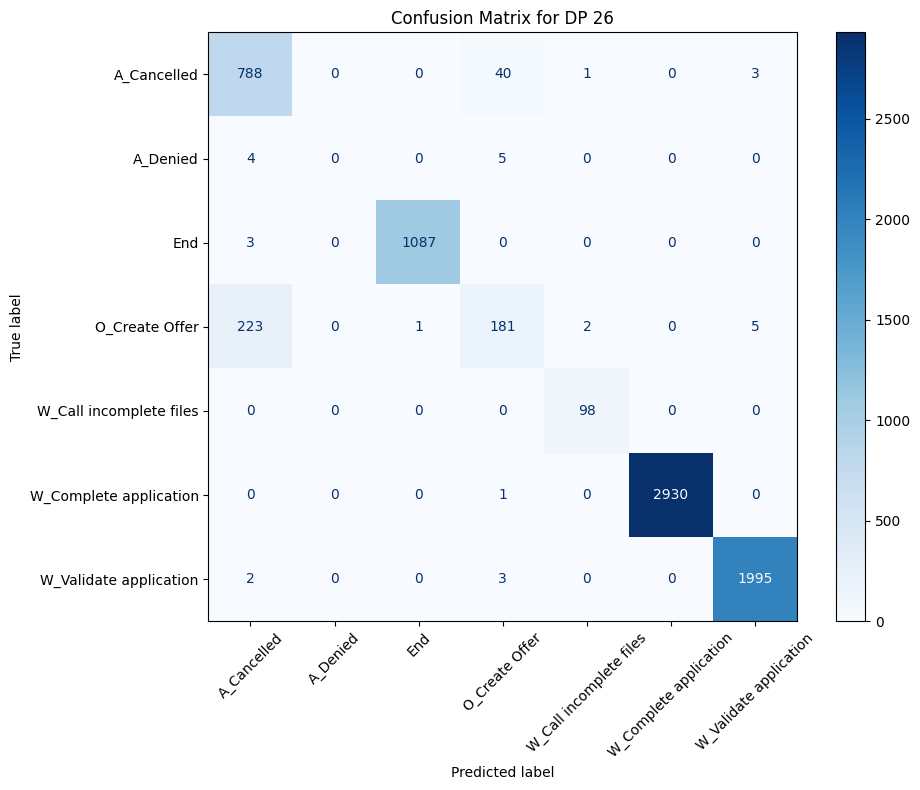

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Comparison for DP 27 (Holdout Set)
Weighted F1 (LSTM):     0.861
Weighted F1 (Baseline): 0.329
Relative Improvement:   161.54%


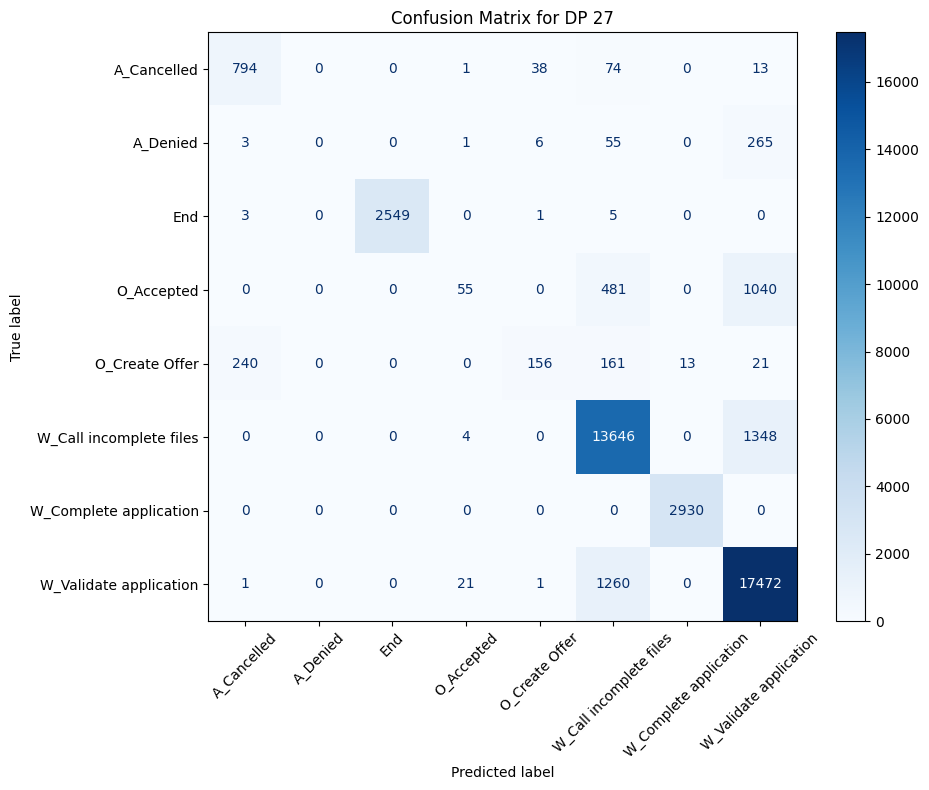

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Comparison for DP 28 (Holdout Set)
Weighted F1 (LSTM):     0.854
Weighted F1 (Baseline): 0.329
Relative Improvement:   159.29%


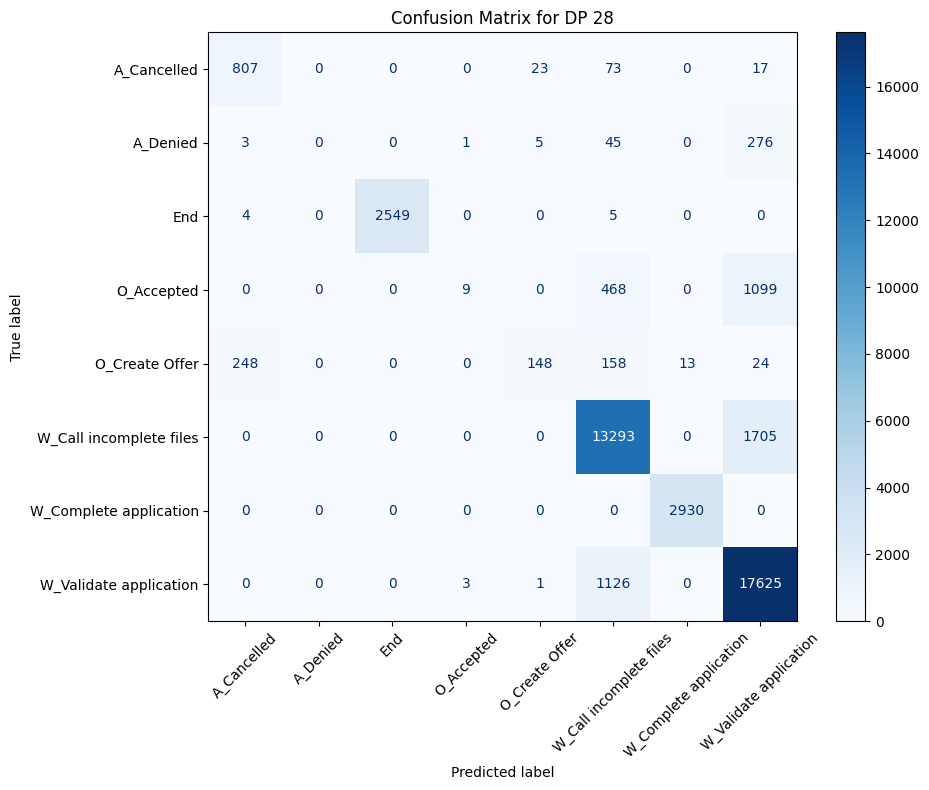

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Comparison for DP 29 (Holdout Set)
Weighted F1 (LSTM):     0.867
Weighted F1 (Baseline): 0.329
Relative Improvement:   163.14%


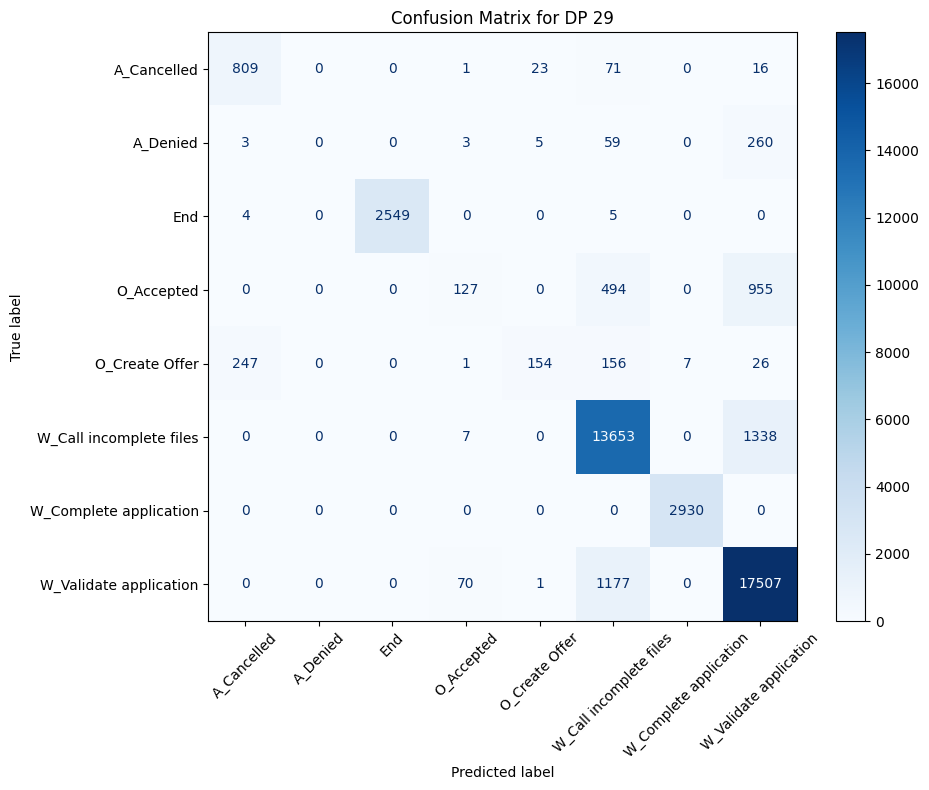

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Comparison for DP 30 (Holdout Set)
Weighted F1 (LSTM):     0.861
Weighted F1 (Baseline): 0.329
Relative Improvement:   161.36%


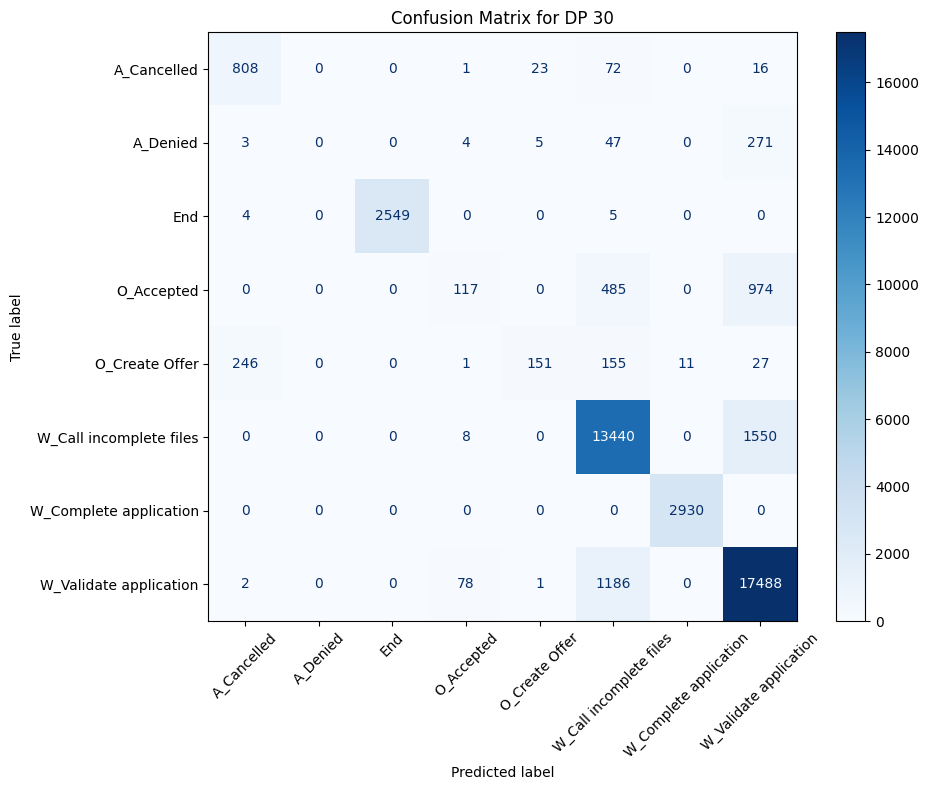

580/580 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Comparison for DP 31 (Holdout Set)
Weighted F1 (LSTM):     0.798
Weighted F1 (Baseline): 0.372
Relative Improvement:   114.89%


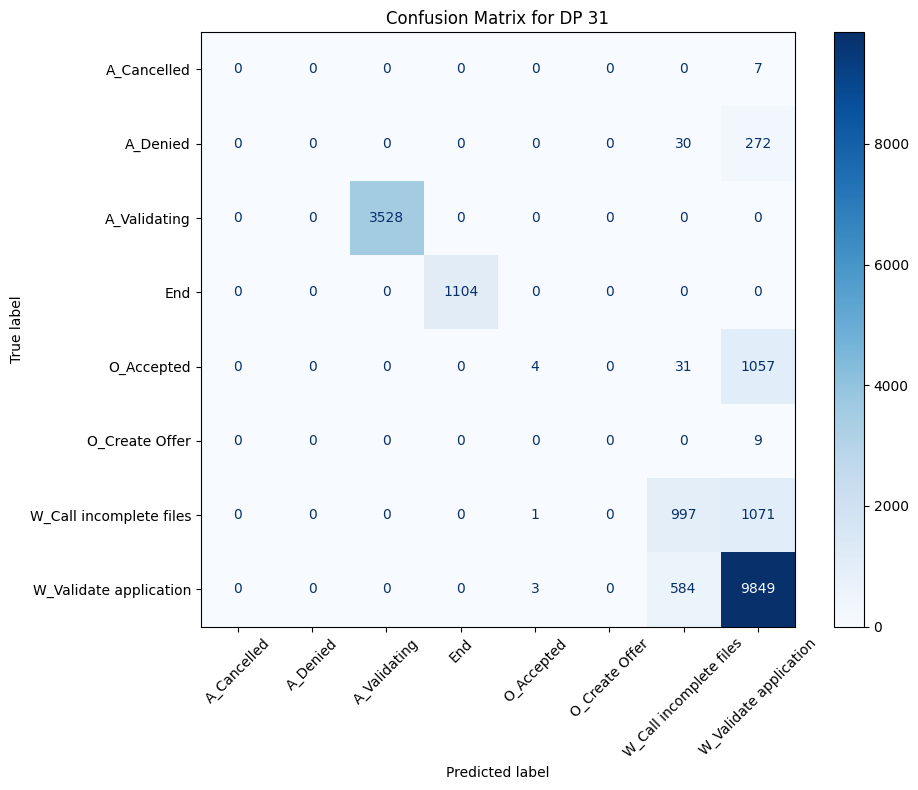

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Comparison for DP 32 (Holdout Set)
Weighted F1 (LSTM):     0.860
Weighted F1 (Baseline): 0.329
Relative Improvement:   161.09%


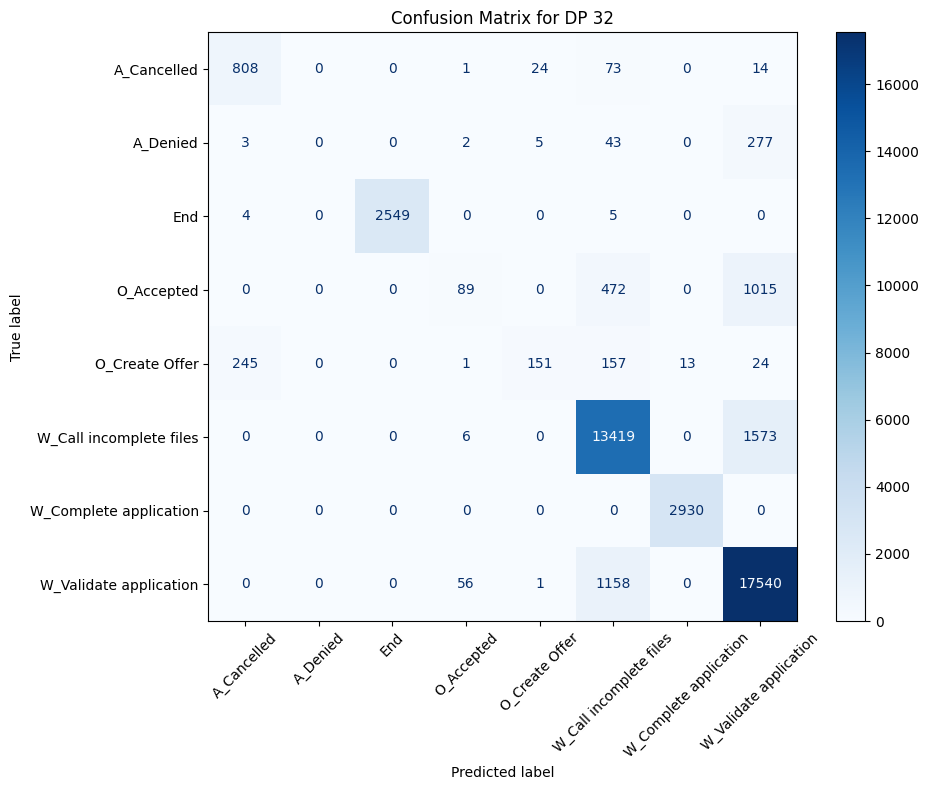

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 33 (Holdout Set)
Weighted F1 (LSTM):     0.947
Weighted F1 (Baseline): 0.508
Relative Improvement:   86.20%


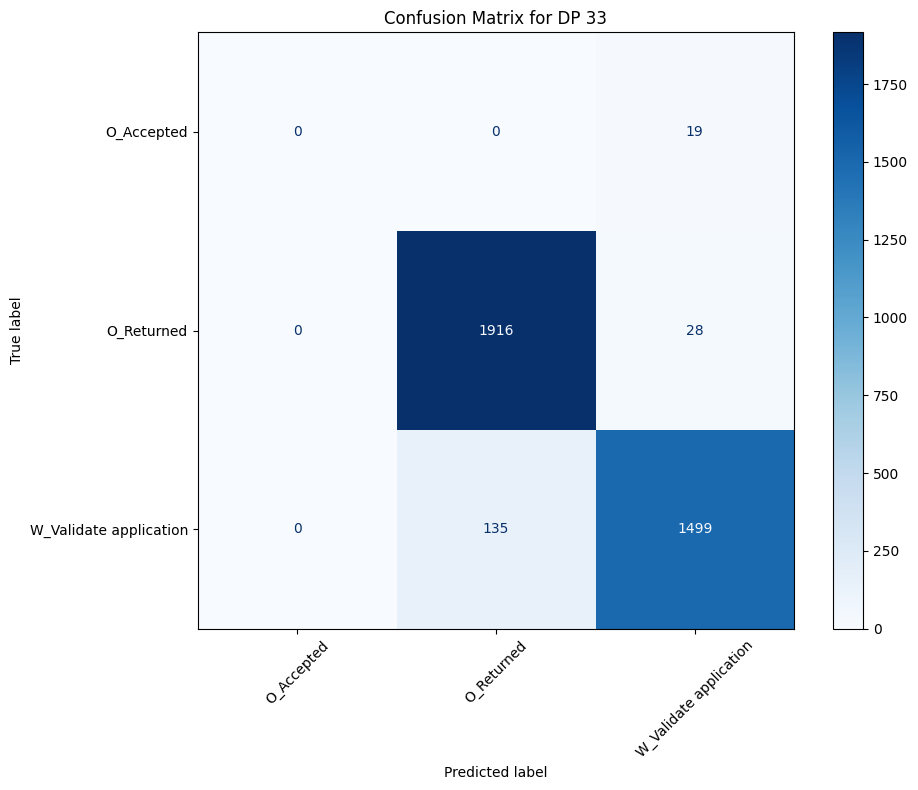

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Comparison for DP 34 (Holdout Set)
Weighted F1 (LSTM):     0.850
Weighted F1 (Baseline): 0.329
Relative Improvement:   157.95%


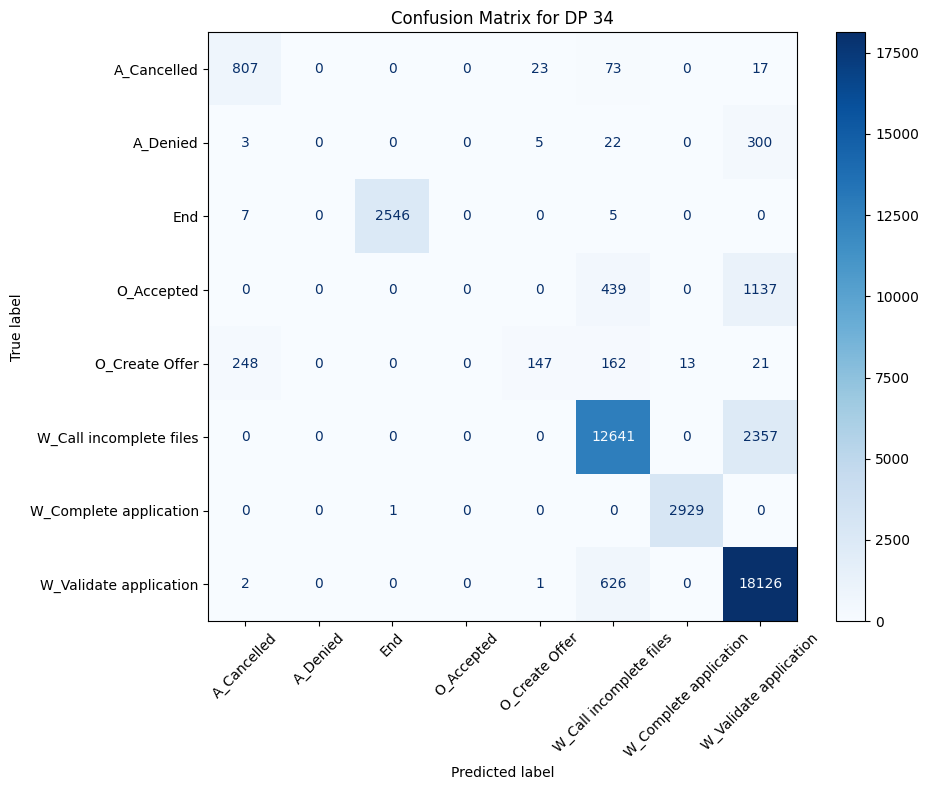

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Comparison for DP 35 (Holdout Set)
Weighted F1 (LSTM):     0.868
Weighted F1 (Baseline): 0.329
Relative Improvement:   163.62%


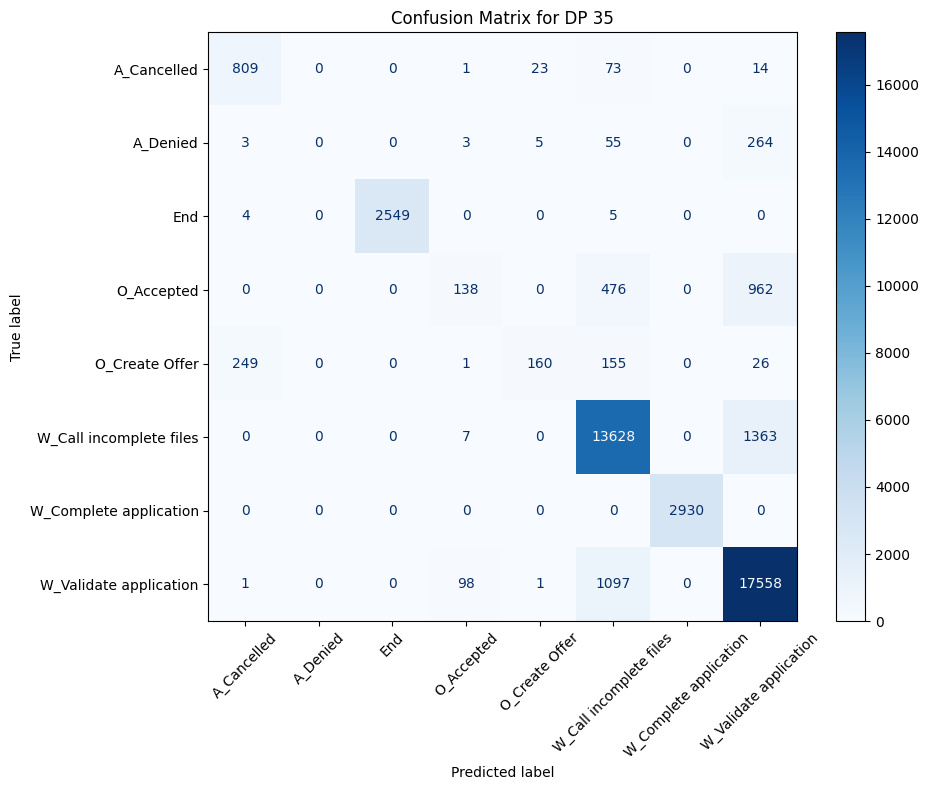

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Comparison for DP 36 (Holdout Set)
Weighted F1 (LSTM):     0.853
Weighted F1 (Baseline): 0.329
Relative Improvement:   158.99%


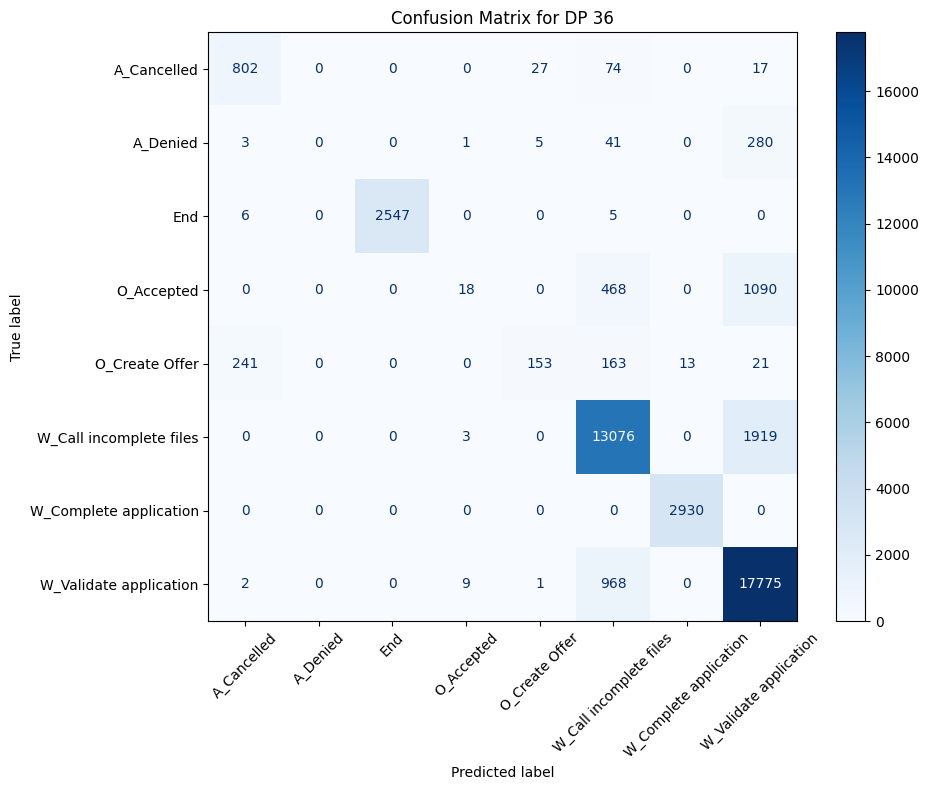

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

Comparison for DP 37 (Holdout Set)
Weighted F1 (LSTM):     0.861
Weighted F1 (Baseline): 0.329
Relative Improvement:   161.51%


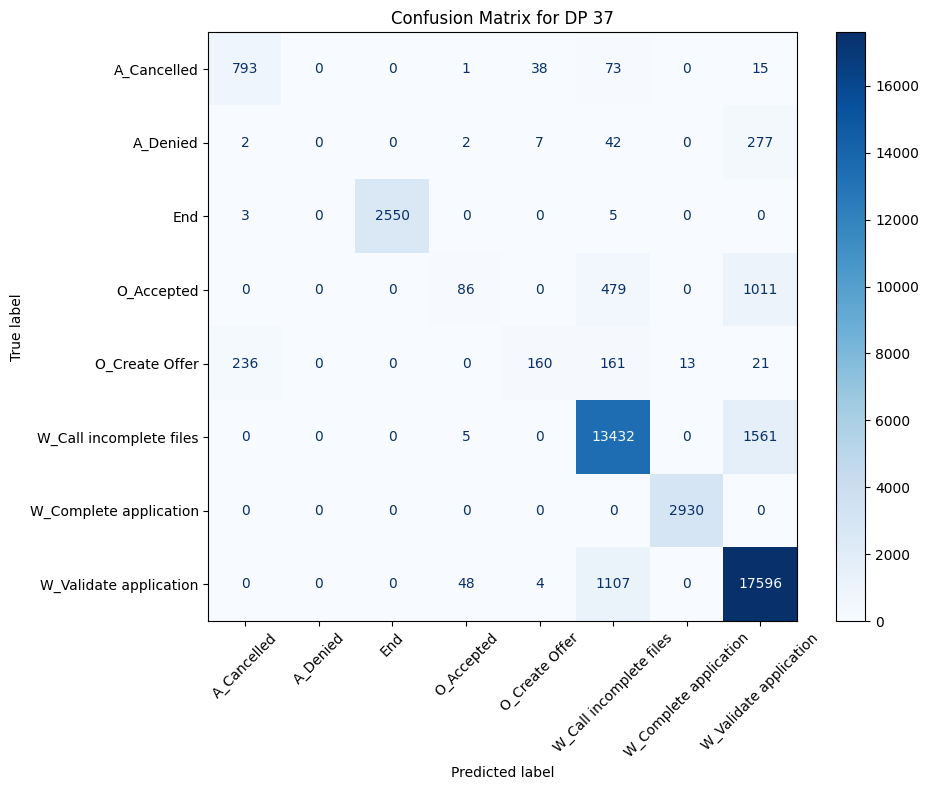

468/468 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

Comparison for DP 39 (Holdout Set)
Weighted F1 (LSTM):     0.863
Weighted F1 (Baseline): 0.504
Relative Improvement:   71.25%


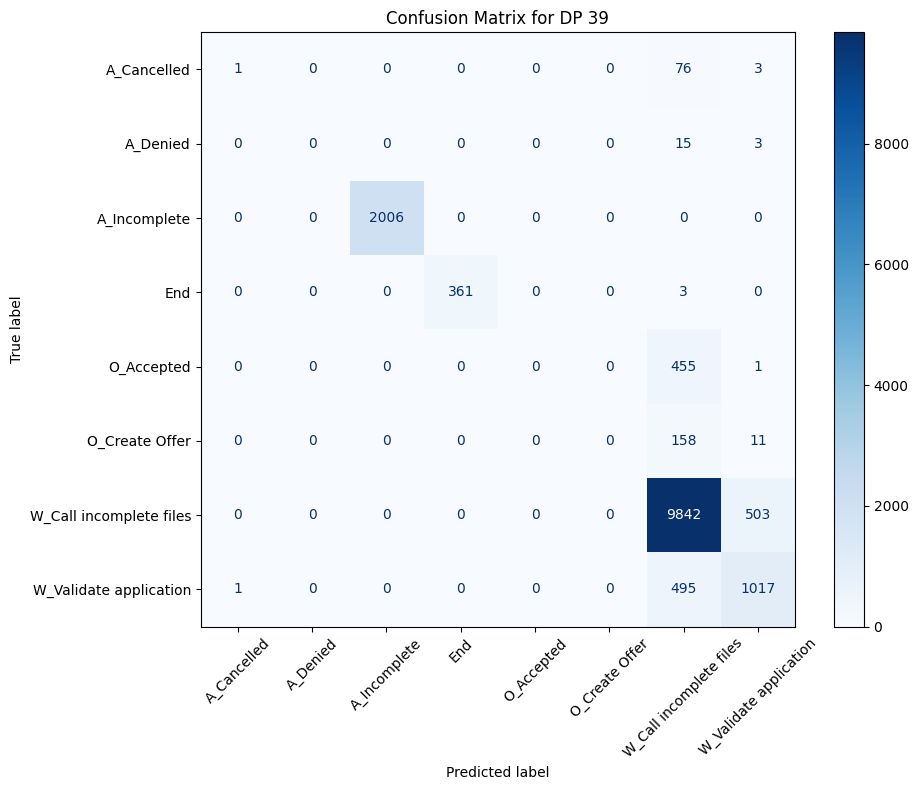

467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Comparison for DP 40 (Holdout Set)
Weighted F1 (LSTM):     0.856
Weighted F1 (Baseline): 0.693
Relative Improvement:   23.53%


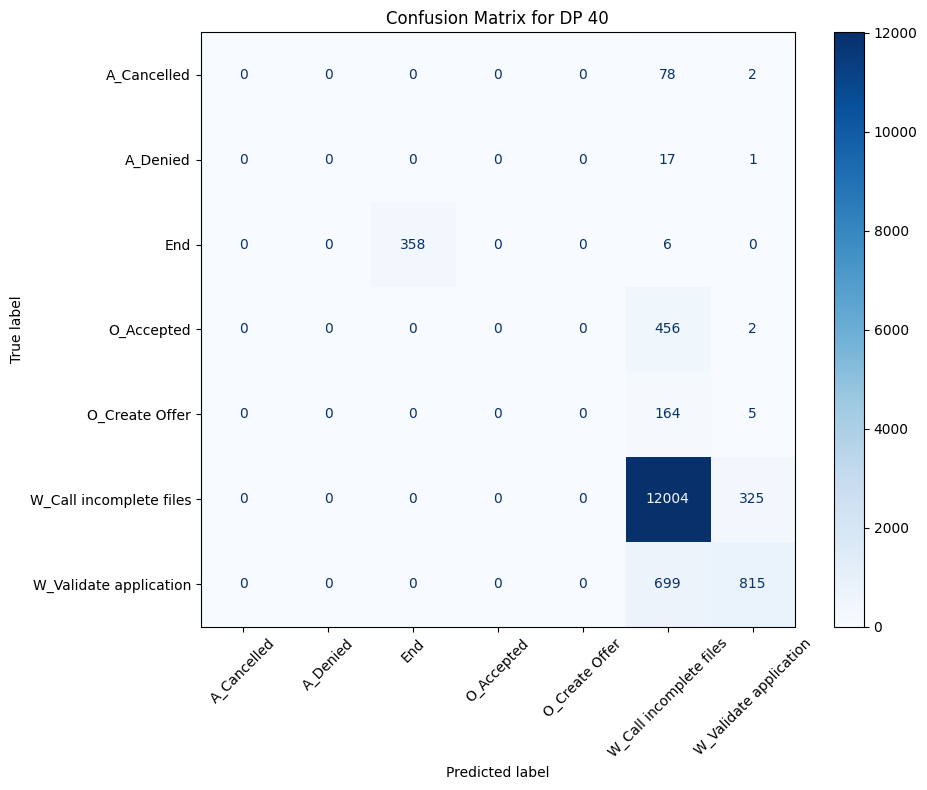

467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

Comparison for DP 41 (Holdout Set)
Weighted F1 (LSTM):     0.859
Weighted F1 (Baseline): 0.693
Relative Improvement:   23.97%


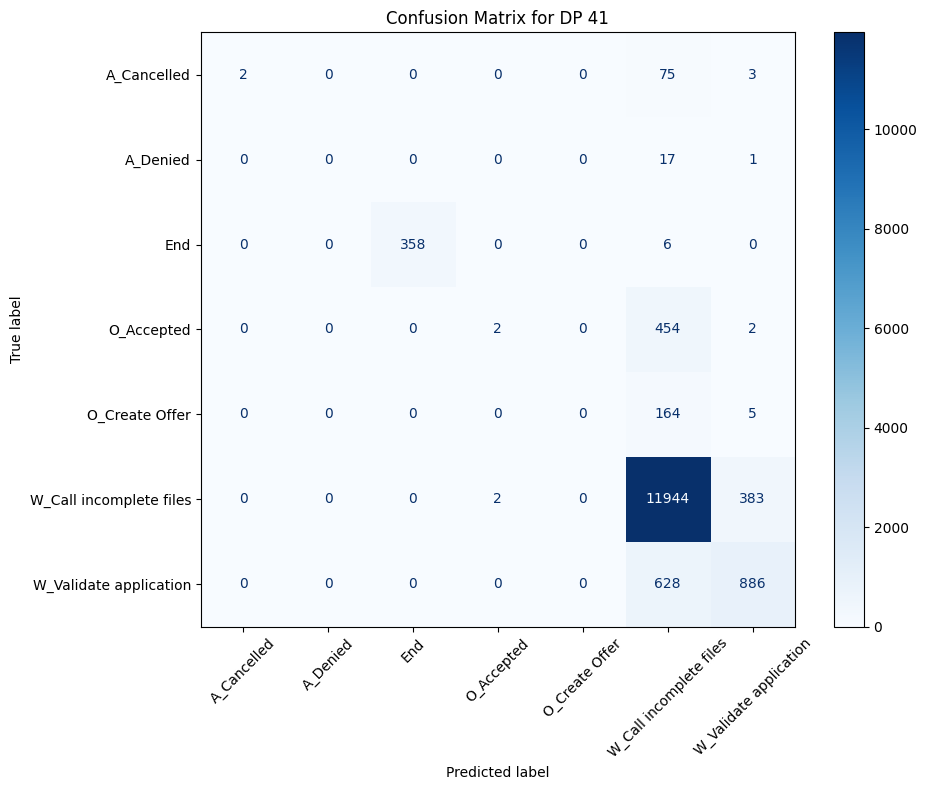

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

Comparison for DP 42 (Holdout Set)
Weighted F1 (LSTM):     0.862
Weighted F1 (Baseline): 0.329
Relative Improvement:   161.83%


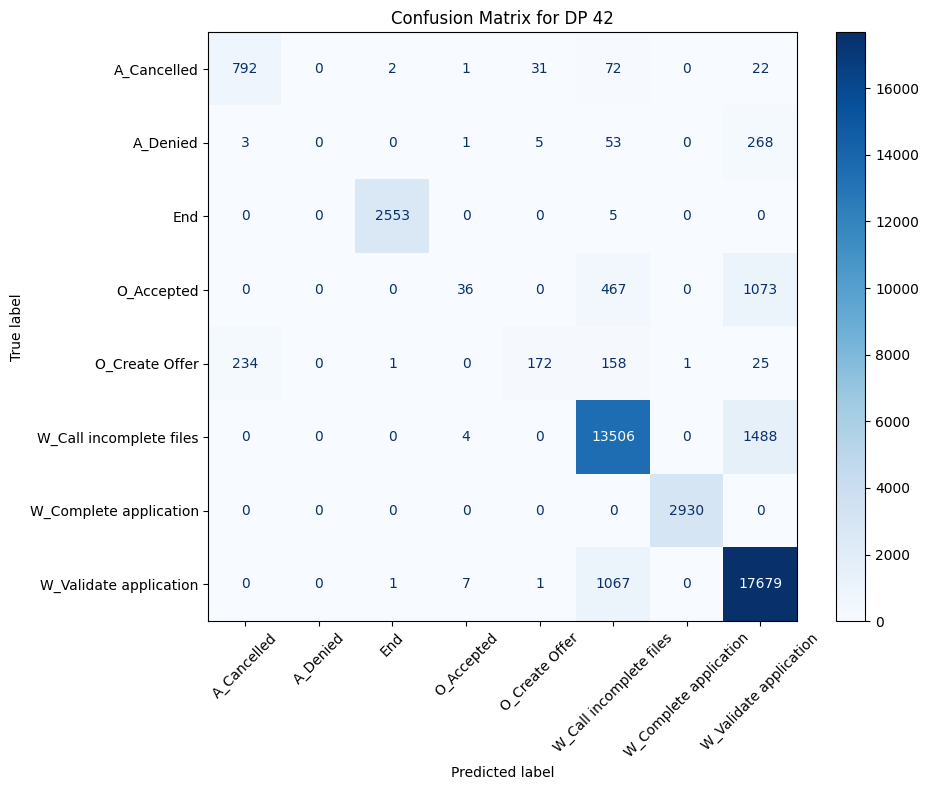

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Comparison for DP 43 (Holdout Set)
Weighted F1 (LSTM):     0.861
Weighted F1 (Baseline): 0.329
Relative Improvement:   161.47%


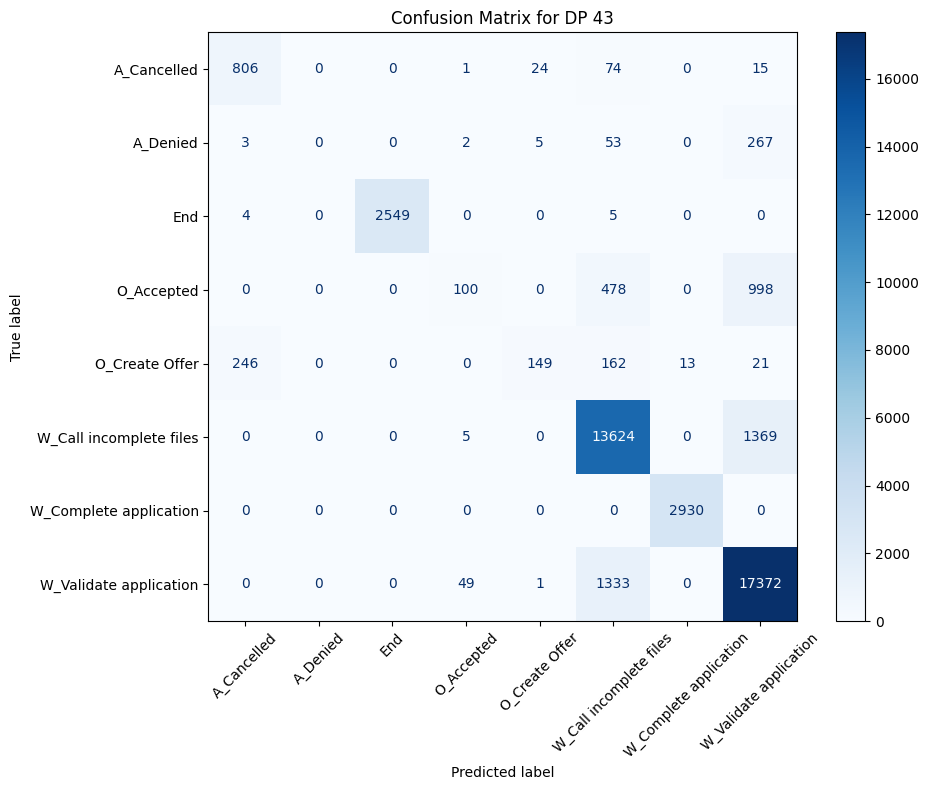

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 44 (Holdout Set)
Weighted F1 (LSTM):     0.824
Weighted F1 (Baseline): 0.431
Relative Improvement:   91.05%


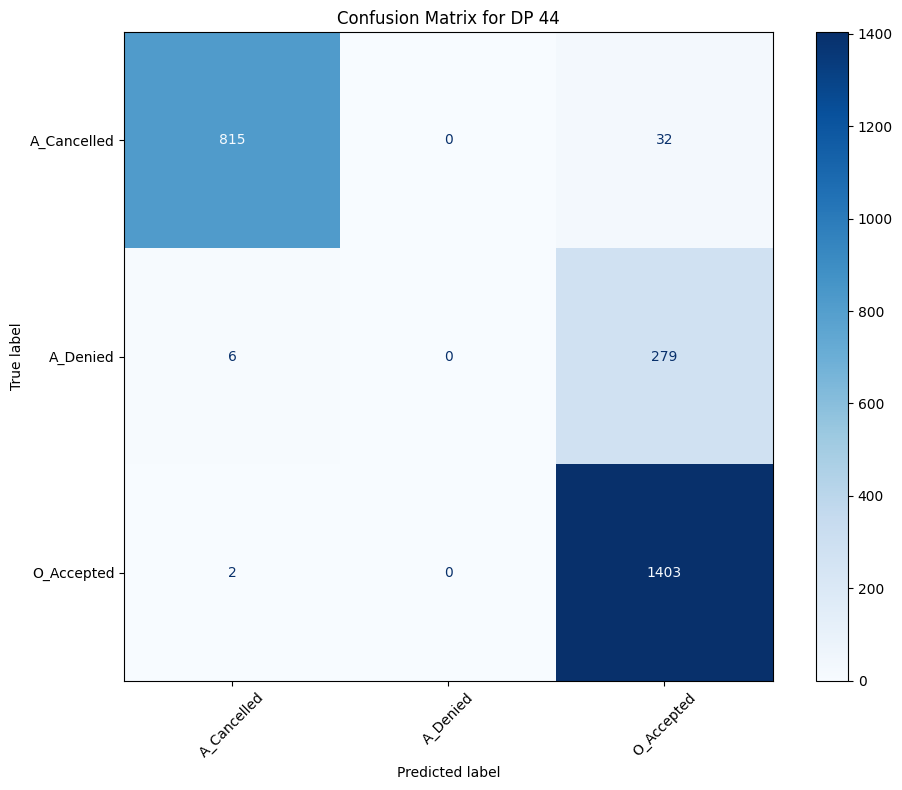

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Comparison for DP 46 (Holdout Set)
Weighted F1 (LSTM):     0.810
Weighted F1 (Baseline): 0.438
Relative Improvement:   85.16%


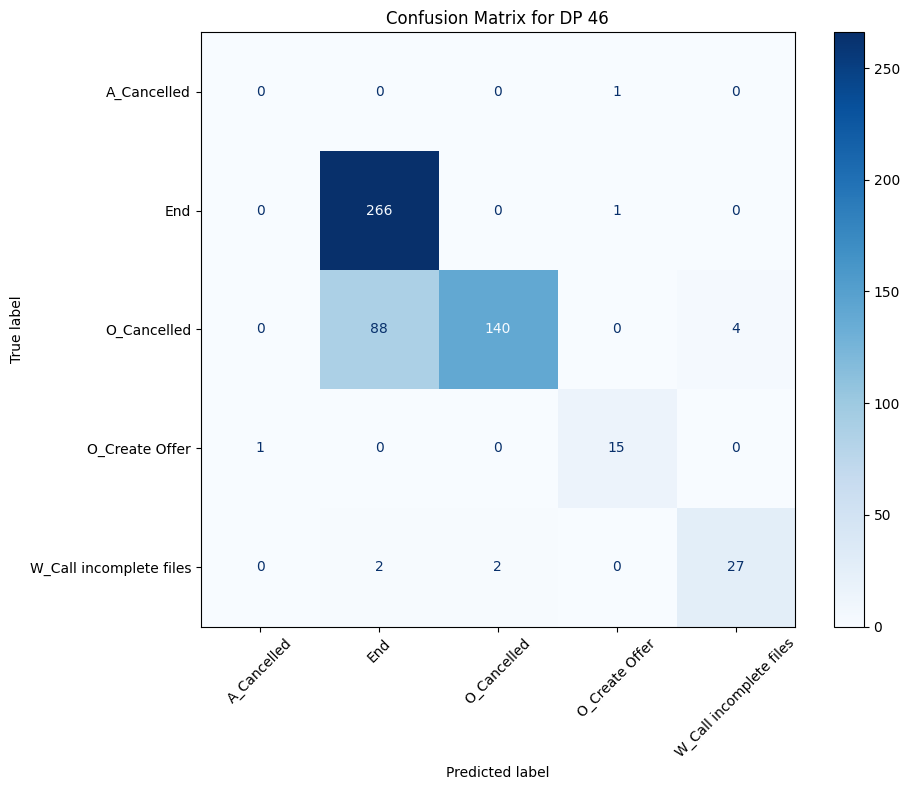

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Comparison for DP 47 (Holdout Set)
Weighted F1 (LSTM):     0.999
Weighted F1 (Baseline): 0.476
Relative Improvement:   110.01%


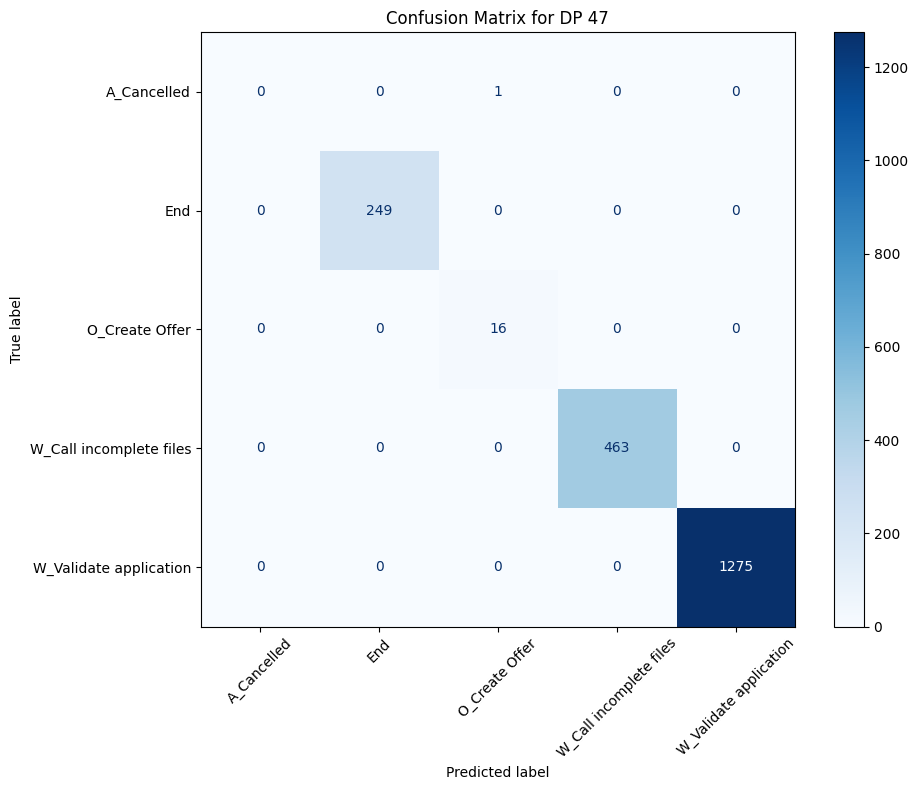

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

Comparison for DP 48 (Holdout Set)
Weighted F1 (LSTM):     0.853
Weighted F1 (Baseline): 0.329
Relative Improvement:   159.07%


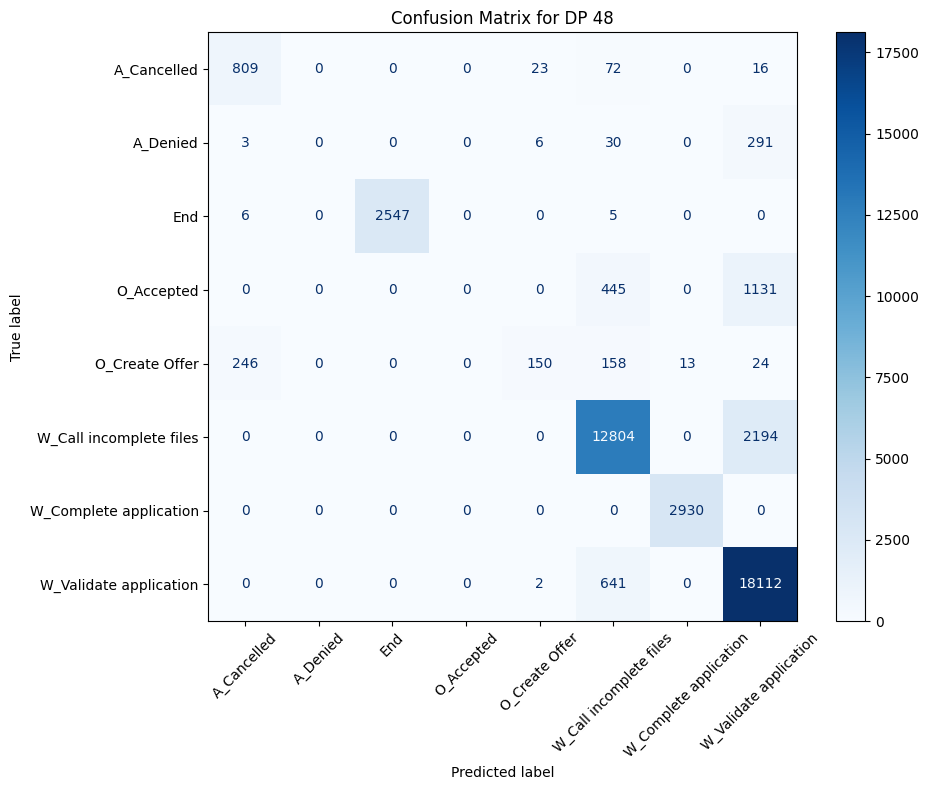

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Comparison for DP 49 (Holdout Set)
Weighted F1 (LSTM):     0.869
Weighted F1 (Baseline): 0.329
Relative Improvement:   163.76%


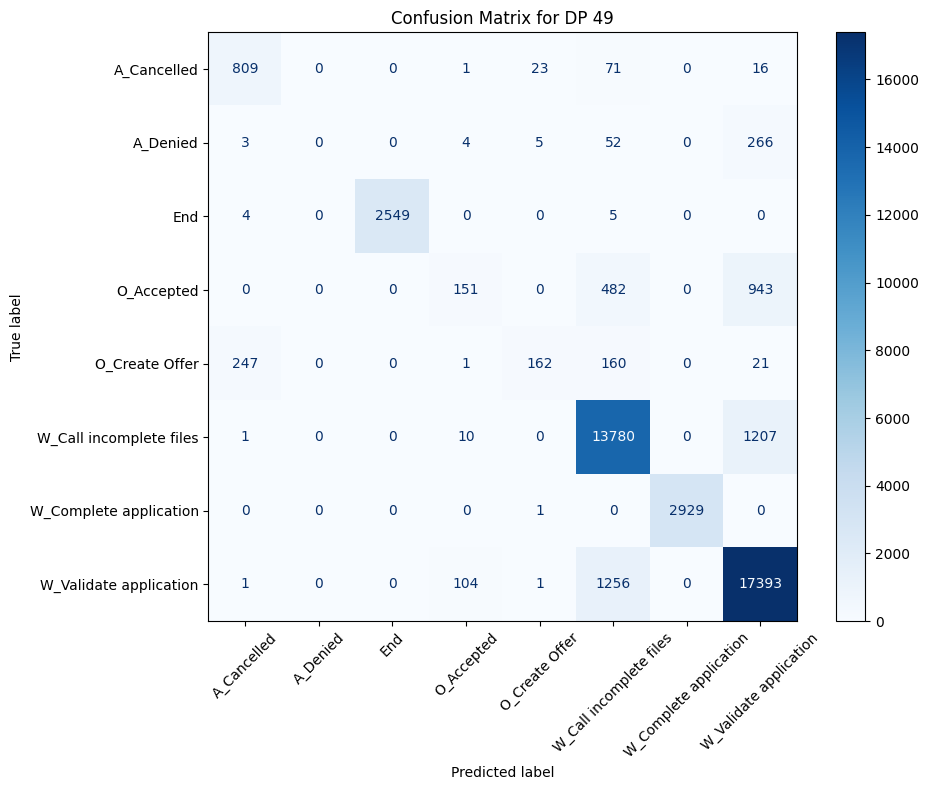

In [18]:
# Step: Build holdout data dict from dp_split_datasets
test_data_per_dp = {
    dp_name: splits["holdout"]
    for dp_name, splits in dp_split_datasets_full_advanced.items()
    if "holdout" in splits and not splits["holdout"].empty
}

# Step: Run evaluation using your existing function
for dp in test_data_per_dp.keys():
    compare_f1_for_trained_model(dp, test_data_per_dp, models_advanced_holdout)

## 1.6 Final Permutation Importance

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7243 - loss: 0.8805 - val_accuracy: 0.9845 - val_loss: 0.0852
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9617 - loss: 0.0988 - val_accuracy: 1.0000 - val_loss: 0.0037
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0183 - val_accuracy: 1.0000 - val_loss: 5.3568e-04
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0075 - val_accuracy: 1.0000 - val_loss: 2.5779e-04
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0033 - val_accuracy: 1.0000 - val_loss: 5.2023e-05
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 1/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8347 - loss: 0.3940 - val_accuracy: 0.9449 - val_loss: 0.1267
Epoch 2/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9440 - loss: 0.1289 - val_accuracy: 0.9996 - val_loss: 0.0043
Epoch 3/

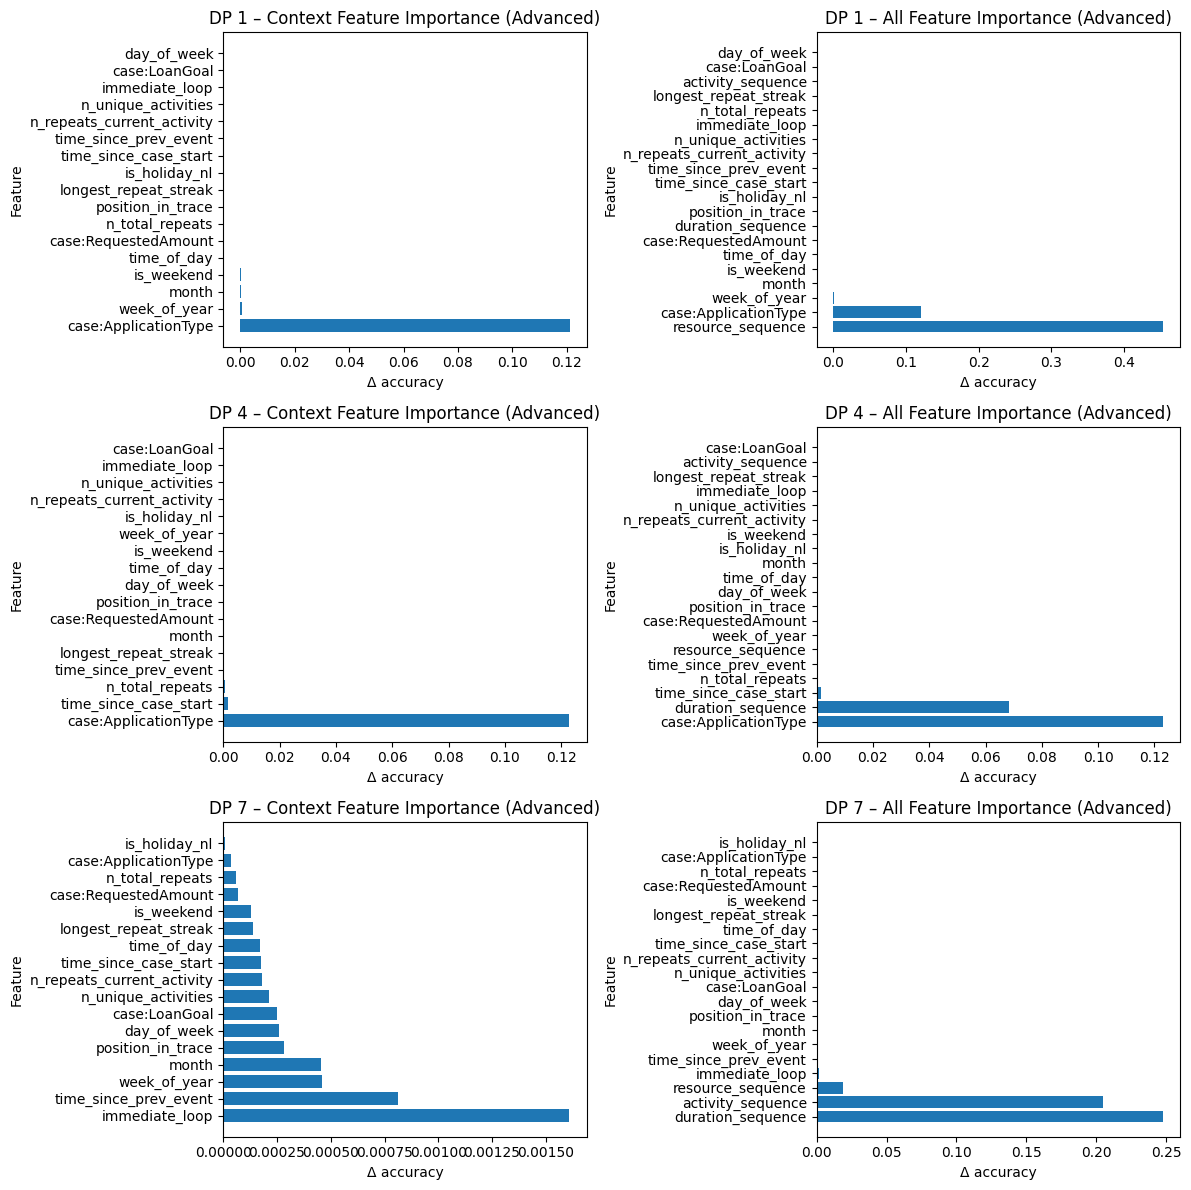

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.optimizers import Adam

# --- Helper ---
def add_unknown_label(encoder):
    if hasattr(encoder, "classes_") and "UNKNOWN" not in encoder.classes_:
        encoder.classes_ = np.append(encoder.classes_, "UNKNOWN")

# --- Config ---
DECISION_POINTS = [
    "DP 1",
    "DP 4",
    "DP 7",
]

CONTEXT_KEYS_ADVANCED = [
    "case:LoanGoal",
    "case:ApplicationType",
    "case:RequestedAmount",
    "position_in_trace",
    "day_of_week",
    "time_of_day",
    "month",
    "week_of_year",
    "is_weekend",
    "is_holiday_nl",
    "time_since_case_start",
    "time_since_prev_event",
    "n_repeats_current_activity",
    "n_unique_activities",
    "immediate_loop",
    "n_total_repeats",
    "longest_repeat_streak"
]

N_REPEATS_CONTEXT = 10
N_REPEATS_ALL     = 10
RANDOM_SEED       = 42

# --- Run (ADVANCED) ---
results_per_dp_advanced = {}
summary_rows_advanced   = []

for dp in DECISION_POINTS:
    splits = dp_split_datasets_full_advanced.get(dp)
    if not splits:
        continue

    df_train = splits.get("train")
    df_test  = splits.get("test")
    if df_train is None or df_test is None or df_train.empty or df_test.empty:
        continue

    # Train on train+test (as in your advanced setup)
    df_combined = pd.concat([df_train, df_test], ignore_index=True)

    # Sequences + encoders
    X_acts_c, X_durs_c, X_res_c, act_enc, res_enc, lbl_enc, y_all, max_len = prepare_sequences_and_labels(df_combined)
    X_ctx_c, ctx_dim, ctx_encoders = prepare_context_attributes(df_combined, CONTEXT_KEYS_ADVANCED)

    # Ensure UNKNOWN tokens
    for enc in (act_enc, res_enc, lbl_enc):
        add_unknown_label(enc)
    for enc in ctx_encoders.values():
        if isinstance(enc, LabelEncoder):
            add_unknown_label(enc)

    # Hyperparameters for this DP
    if dp not in df_hyperparams_summary.index:
        continue
    params = df_hyperparams_summary.loc[dp]
    embedding_dim = int(params["embedding_dim"])
    lstm_units    = int(params["lstm_units"])
    dropout_rate  = float(params["dropout_rate"])
    learning_rate = float(params["learning_rate"])

    # Build, compile, train (advanced methods)
    model = build_lstm_model_advanced(
        num_activities=len(act_enc.classes_),
        num_resources=len(res_enc.classes_),
        context_dim=ctx_dim,
        max_seq_len=max_len,
        num_classes=len(lbl_enc.classes_),
        embedding_dim=embedding_dim,
        lstm_units=lstm_units,
        dropout_rate=dropout_rate
    )
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    train_model_advanced(model, [X_acts_c, X_durs_c, X_res_c, X_ctx_c], y_all)

    # Test tensors
    X_acts_t, X_durs_t, X_res_t, _, _, _, y_test, _ = prepare_sequences_and_labels(df_test)
    X_ctx_t, _, _ = prepare_context_attributes(df_test, CONTEXT_KEYS_ADVANCED)

    # Permutation importances
    ctx_importances = permutation_importance_context(
        model, X_acts_t, X_durs_t, X_res_t, X_ctx_t, y_test,
        feature_names=CONTEXT_KEYS_ADVANCED, n_repeats=N_REPEATS_CONTEXT, random_state=RANDOM_SEED
    )
    importances_all, feat_names_all, baseline_acc = permutation_importance_all_features(
        model, [X_acts_t, X_durs_t, X_res_t, X_ctx_t], y_test,
        CONTEXT_KEYS_ADVANCED, n_repeats=N_REPEATS_ALL, random_state=RANDOM_SEED
    )

    # Store
    results_per_dp_advanced[dp] = {
        "model": model,
        "activity_encoder": act_enc,
        "resource_encoder": res_enc,
        "label_encoder": lbl_enc,
        "context_keys": CONTEXT_KEYS_ADVANCED,
        "context_encoders": ctx_encoders,
        "max_seq_len": max_len,
        "context_importance": pd.Series(ctx_importances, index=CONTEXT_KEYS_ADVANCED),
        "all_importance": pd.Series(importances_all, index=feat_names_all),
        "baseline_accuracy": baseline_acc,
        "n_test_samples": int(len(X_acts_t)),
    }

    row = {
        "decision_point": dp,
        "baseline_accuracy": baseline_acc,
        "n_test_samples": int(len(X_acts_t))
    }
    for feat, imp in zip(CONTEXT_KEYS_ADVANCED, ctx_importances):
        row[f"ctx::{feat}"] = float(imp)
    for feat, imp in zip(feat_names_all, importances_all):
        row[f"all::{feat}"] = float(imp)
    summary_rows_advanced.append(row)

# Summary table (advanced)
df_dp_summary_advanced = pd.DataFrame(summary_rows_advanced).sort_values(by="decision_point").reset_index(drop=True)

# --- Grid plots (advanced): up to 3 DPs, two subplots each ---
dps_to_plot_adv = [dp for dp in DECISION_POINTS if dp in results_per_dp_advanced][:3]
if dps_to_plot_adv:
    fig, axes = plt.subplots(len(dps_to_plot_adv), 2, figsize=(12, 4 * len(dps_to_plot_adv)), squeeze=False)

    for i, dp in enumerate(dps_to_plot_adv):
        ctx = results_per_dp_advanced[dp]["context_importance"].sort_values(ascending=True)
        all_imp = results_per_dp_advanced[dp]["all_importance"].sort_values(ascending=True)

        ax = axes[i, 0]
        ax.barh(ctx.index, ctx.values)
        ax.invert_yaxis()
        ax.set_title(f"{dp} – Context Feature Importance (Advanced)")
        ax.set_xlabel("Δ accuracy")
        ax.set_ylabel("Feature")

        ax = axes[i, 1]
        ax.barh(all_imp.index, all_imp.values)
        ax.invert_yaxis()
        ax.set_title(f"{dp} – All Feature Importance (Advanced)")
        ax.set_xlabel("Δ accuracy")
        ax.set_ylabel("Feature")

    fig.tight_layout()
    plt.show()

In [20]:
results_dir = (Path.cwd().parent / "results") if Path.cwd().name == "notebooks" else Path("../results")
results_dir.mkdir(parents=True, exist_ok=True)

# use existing fig handle if available; otherwise grab current figure
try:
    _fig = fig
except NameError:
    _fig = plt.gcf()

save_path = results_dir / "feature_importance_grid_advanced.png"
_fig.savefig(save_path, dpi=200, bbox_inches="tight")
print(f"Plot saved to: {save_path.resolve()}")

Plot saved to: /Users/m.ohmayer/Desktop/next_activity_prediction/results/feature_importance_grid_advanced.png


## 1.7 Evaluation Plots and Metrics

In [27]:
# --- Per-Decision Point Aggregates ---
dp_metrics_lstm = df_accuracy.groupby("decision_point").apply(
    lambda g: pd.Series({
        "precision": (g["precision"] * g["support"]).sum() / g["support"].sum(),
        "recall": (g["recall"] * g["support"]).sum() / g["support"].sum(),
        "f1_score": (g["f1_score"] * g["support"]).sum() / g["support"].sum()
    })
)

dp_metrics_baseline = df_baseline.groupby("decision_point").apply(
    lambda g: pd.Series({
        "precision": (g["precision"] * g["support"]).sum() / g["support"].sum(),
        "recall": (g["recall"] * g["support"]).sum() / g["support"].sum(),
        "f1_score": (g["f1_score"] * g["support"]).sum() / g["support"].sum()
    })
)


OUT_DIR = Path("../data/evaluation")
OUT_DIR.mkdir(parents=True, exist_ok=True)

joblib.dump(dp_metrics_lstm,     OUT_DIR / "dp_metrics_lstm_advanced.joblib")

/var/folders/ct/jknbc8jj3yb54ssrdbml90z00000gn/T/ipykernel_63608/1279891679.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dp_metrics_lstm = df_accuracy.groupby("decision_point").apply(
/var/folders/ct/jknbc8jj3yb54ssrdbml90z00000gn/T/ipykernel_63608/1279891679.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dp_metrics_baseline = df_baseline.groupby("decision_point").apply(


['../data/evaluation/dp_metrics_lstm_advanced.joblib']

In [28]:
# --- Mean and Std per model ---
mean_precision_lstm = dp_metrics_lstm["precision"].mean()
std_precision_lstm = dp_metrics_lstm["precision"].std()

mean_recall_lstm = dp_metrics_lstm["recall"].mean()
std_recall_lstm = dp_metrics_lstm["recall"].std()

mean_f1_lstm = dp_metrics_lstm["f1_score"].mean()
std_f1_lstm = dp_metrics_lstm["f1_score"].std()

mean_precision_baseline = dp_metrics_baseline["precision"].mean()
std_precision_baseline = dp_metrics_baseline["precision"].std()

mean_recall_baseline = dp_metrics_baseline["recall"].mean()
std_recall_baseline = dp_metrics_baseline["recall"].std()

mean_f1_baseline = dp_metrics_baseline["f1_score"].mean()
std_f1_baseline = dp_metrics_baseline["f1_score"].std()

# --- Print Global + Std ---
print("\n=== Aggregated Across Decision Points ===")
print(f"Precision (LSTM):     {mean_precision_lstm:.3f} ± {std_precision_lstm:.3f}")
print(f"Precision (Baseline): {mean_precision_baseline:.3f} ± {std_precision_baseline:.3f}\n")

print(f"Recall (LSTM):        {mean_recall_lstm:.3f} ± {std_recall_lstm:.3f}")
print(f"Recall (Baseline):    {mean_recall_baseline:.3f} ± {std_recall_baseline:.3f}\n")

print(f"F1-score (LSTM):      {mean_f1_lstm:.3f} ± {std_f1_lstm:.3f}")
print(f"F1-score (Baseline):  {mean_f1_baseline:.3f} ± {std_f1_baseline:.3f}")


=== Aggregated Across Decision Points ===
Precision (LSTM):     88.536 ± 6.556
Precision (Baseline): 49.392 ± 18.730

Recall (LSTM):        90.365 ± 5.555
Recall (Baseline):    49.363 ± 18.671

F1-score (LSTM):      88.703 ± 6.415
F1-score (Baseline):  49.376 ± 18.701


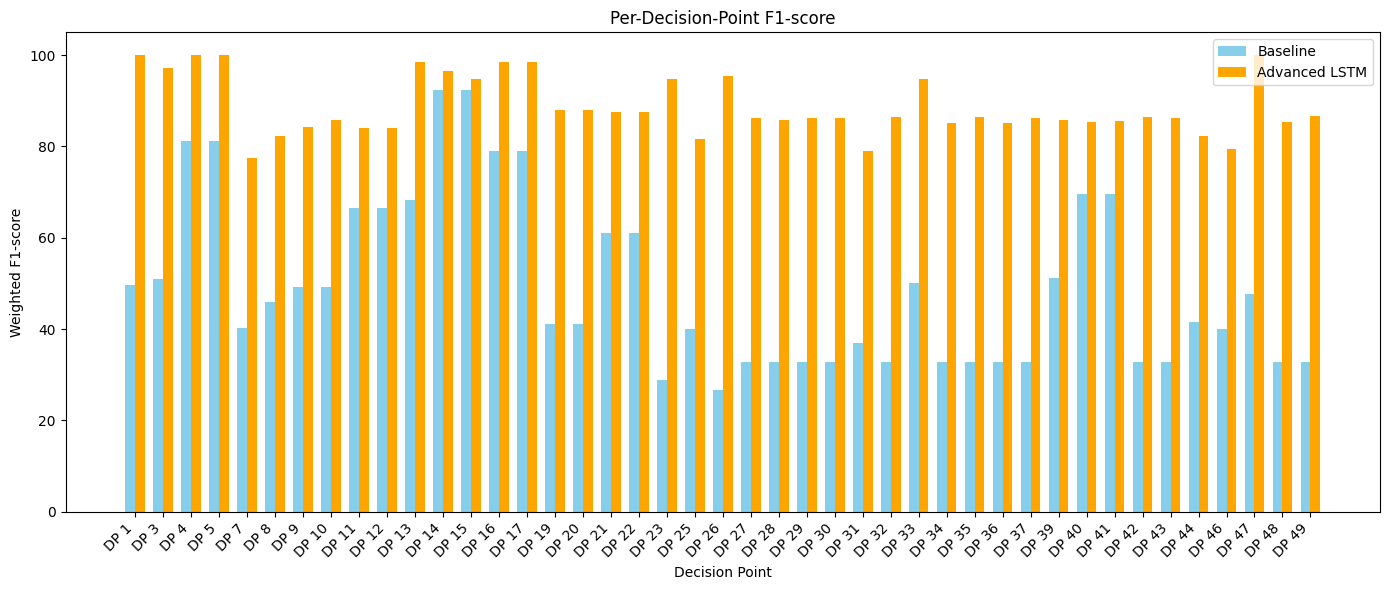

In [30]:
# Combine metrics
dp_metrics = pd.DataFrame({
    "baseline_f1": dp_metrics_baseline["f1_score"],
    "lstm_f1": dp_metrics_lstm["f1_score"]
})

# Extract numeric part for sorting
def extract_dp_number(dp_name):
    match = re.search(r'\d+', dp_name)
    return int(match.group()) if match else float('inf')

dp_metrics["dp_number"] = dp_metrics.index.map(extract_dp_number)
dp_metrics = dp_metrics.sort_values("dp_number")

# Plot
x = np.arange(len(dp_metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(x - width/2, dp_metrics["baseline_f1"], width, label="Baseline", color="skyblue")
bars2 = ax.bar(x + width/2, dp_metrics["lstm_f1"], width, label="Advanced LSTM", color="orange")

ax.set_xlabel("Decision Point")
ax.set_ylabel("Weighted F1-score")
ax.set_title("Per-Decision-Point F1-score")
ax.set_xticks(x)
ax.set_xticklabels(dp_metrics.index, rotation=45, ha="right")
ax.legend()

plt.tight_layout()
plt.show()

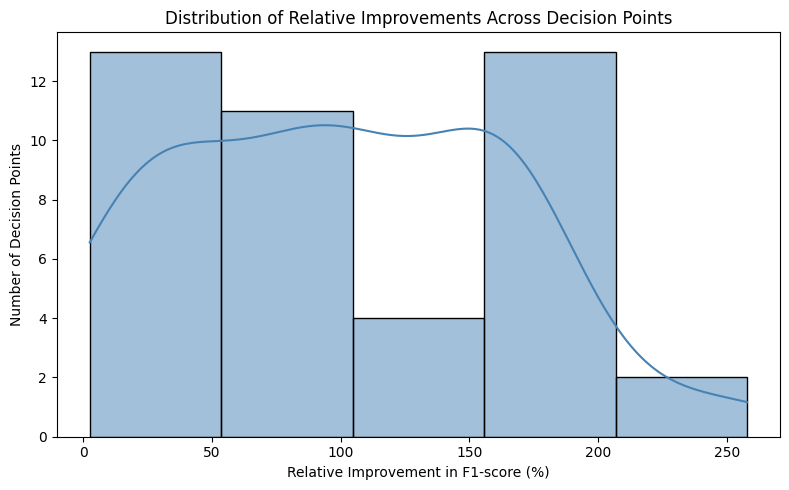

In [31]:
# Calculate %ΔF1 for each decision point
relative_improvement_f1_dp = (
    (dp_metrics_lstm["f1_score"] - dp_metrics_baseline["f1_score"])
    / dp_metrics_baseline["f1_score"] * 100
)

# Plot histogram + KDE
plt.figure(figsize=(8, 5))
sns.histplot(relative_improvement_f1_dp, bins=5, kde=True, color="steelblue", edgecolor="black")

# Labels and title
plt.xlabel("Relative Improvement in F1-score (%)")
plt.ylabel("Number of Decision Points")
plt.title("Distribution of Relative Improvements Across Decision Points")

plt.tight_layout()
plt.show()

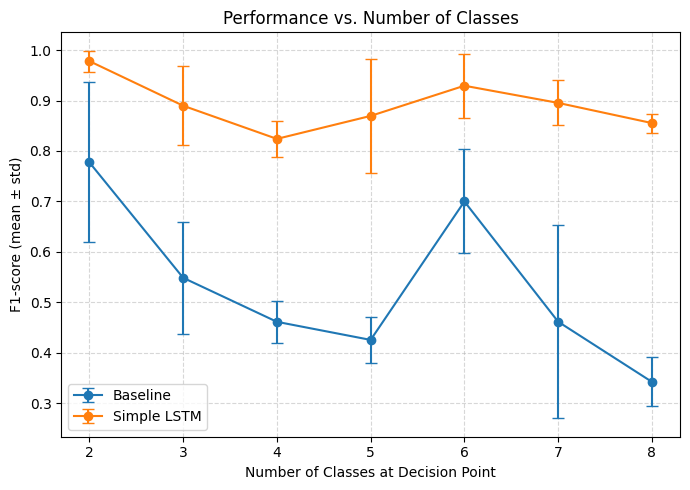

In [32]:
# --- 1. Get number of classes per decision point ---
num_classes_per_dp = (
    df_accuracy.groupby("decision_point")["label"]
    .nunique()
    .reset_index()
    .rename(columns={"label": "num_classes"})
)

# --- 2. Merge per-DP metrics with number of classes ---
dp_perf = pd.merge(
    dp_metrics_lstm.reset_index(),
    dp_metrics_baseline.reset_index(),
    on="decision_point",
    suffixes=("_lstm", "_baseline")
)
dp_perf = pd.merge(dp_perf, num_classes_per_dp, on="decision_point")

# --- 3. Convert percentage values to fraction scale ---
metric_cols = ["precision_lstm", "recall_lstm", "f1_score_lstm",
               "precision_baseline", "recall_baseline", "f1_score_baseline"]

for col in metric_cols:
    if dp_perf[col].max() > 1:  # Means it's in percentage
        dp_perf[col] = dp_perf[col] / 100.0

# --- 4. Group by num_classes and calculate mean & std (numeric only) ---
grouped = dp_perf.groupby("num_classes")[metric_cols].agg(["mean", "std"])

# --- 5. Plot Baseline vs LSTM F1-score with error bars ---
plt.figure(figsize=(7, 5))
plt.errorbar(
    grouped.index, grouped["f1_score_baseline"]["mean"],
    yerr=grouped["f1_score_baseline"]["std"],
    fmt='o-', capsize=4, label="Baseline"
)
plt.errorbar(
    grouped.index, grouped["f1_score_lstm"]["mean"],
    yerr=grouped["f1_score_lstm"]["std"],
    fmt='o-', capsize=4, label="Simple LSTM"
)

plt.xlabel("Number of Classes at Decision Point")
plt.ylabel("F1-score (mean ± std)")
plt.title("Performance vs. Number of Classes")
plt.xticks(grouped.index)  # Show exact class counts on x-axis
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

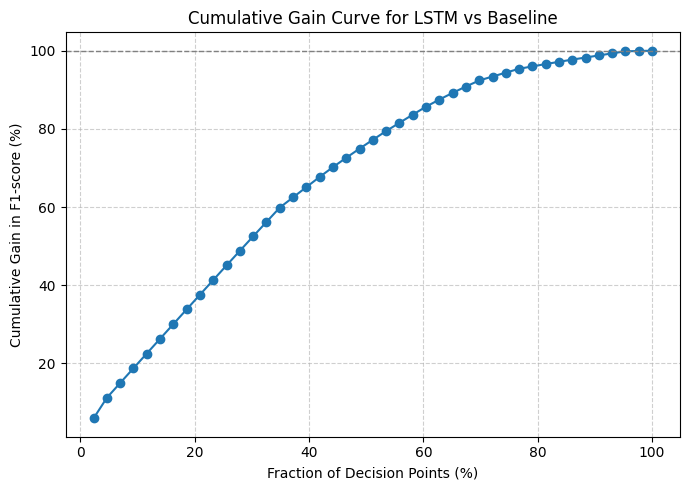

In [33]:
# --- 1. Calculate %ΔF1 per DP ---
dp_improvement = (
    (dp_metrics_lstm["f1_score"] - dp_metrics_baseline["f1_score"]) /
    dp_metrics_baseline["f1_score"] * 100
).sort_values(ascending=False)

# --- 2. Compute cumulative sum (normalized to 100%) ---
cumulative_gain = dp_improvement.cumsum()
cumulative_gain_normalized = cumulative_gain / cumulative_gain.iloc[-1] * 100

# --- 3. X-axis: fraction of decision points ---
dp_fraction = np.arange(1, len(dp_improvement) + 1) / len(dp_improvement) * 100

# --- 4. Plot ---
plt.figure(figsize=(7, 5))
plt.plot(dp_fraction, cumulative_gain_normalized, marker="o")
plt.axhline(100, color="gray", linestyle="--", linewidth=1)

plt.xlabel("Fraction of Decision Points (%)")
plt.ylabel("Cumulative Gain in F1-score (%)")
plt.title("Cumulative Gain Curve for LSTM vs Baseline")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

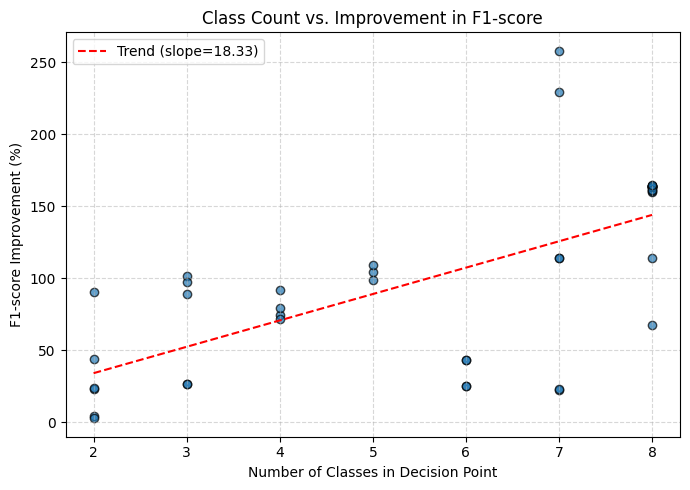

In [34]:
# --- 1. Calculate %ΔF1 per DP ---
dp_improvement = (
    (dp_metrics_lstm["f1_score"] - dp_metrics_baseline["f1_score"]) /
    dp_metrics_baseline["f1_score"] * 100
)

# --- 2. Get number of classes per DP ---
num_classes_per_dp = df_accuracy.groupby("decision_point")["label"].nunique()

# Align with dp_improvement index
num_classes_per_dp = num_classes_per_dp.loc[dp_improvement.index]

# --- 3. Scatter plot ---
plt.figure(figsize=(7, 5))
plt.scatter(num_classes_per_dp, dp_improvement, alpha=0.7, edgecolor="black")

# --- 4. Fit regression line ---
coef = np.polyfit(num_classes_per_dp, dp_improvement, 1)
poly1d_fn = np.poly1d(coef)
x_vals = np.linspace(num_classes_per_dp.min(), num_classes_per_dp.max(), 100)
plt.plot(x_vals, poly1d_fn(x_vals), color="red", linestyle="--", label=f"Trend (slope={coef[0]:.2f})")

# --- 5. Labels & formatting ---
plt.xlabel("Number of Classes in Decision Point")
plt.ylabel("F1-score Improvement (%)")
plt.title("Class Count vs. Improvement in F1-score")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## 1.8 Final Training & Storage

In [21]:
# --- Storage ---
final_models_trained_on_full_data = {}

# Loop over all decision points
for dp_name in df_hyperparams_summary.index:
    print(f"\nRetraining on FULL dataset for: {dp_name}")

    try:
        # Get all data splits
        splits = dp_split_datasets_full_advanced.get(dp_name)
        if not splits:
            print(f"No data available for {dp_name}")
            continue

        # Combine all data: train + test + holdout
        df_full = pd.concat([splits["train"], splits["test"], splits["holdout"]], ignore_index=True)

        # Prepare inputs
        X_acts, X_durs, X_res, act_enc, res_enc, label_enc, y_full, max_seq_len = prepare_sequences_and_labels(df_full)
        X_ctx, context_dim, context_encoders = prepare_context_attributes(df_full, context_keys_advanced)

        # Add "UNKNOWN" to all label encoders (if not already present)
        def ensure_unknown(encoder):
            if "UNKNOWN" not in encoder.classes_:
                encoder.classes_ = np.append(encoder.classes_, "UNKNOWN")

        ensure_unknown(act_enc)
        ensure_unknown(res_enc)
        ensure_unknown(label_enc)
        for enc in context_encoders.values():
            if isinstance(enc, LabelEncoder):
                ensure_unknown(enc)

        # Get hyperparameters
        params = df_hyperparams_summary.loc[dp_name]
        embedding_dim = int(params["embedding_dim"])
        lstm_units = int(params["lstm_units"])
        dropout_rate = float(params["dropout_rate"])
        learning_rate = float(params["learning_rate"])
        num_classes = len(label_enc.classes_)

        # Build model
        model = build_lstm_model_advanced(
            num_activities=len(act_enc.classes_),
            num_resources=len(res_enc.classes_),
            context_dim=context_dim,
            max_seq_len=max_seq_len,
            num_classes=num_classes,
            embedding_dim=embedding_dim,
            lstm_units=lstm_units,
            dropout_rate=dropout_rate
        )

        # Compile model
        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

        train_model_advanced(model, [X_acts, X_durs, X_res, X_ctx], y_full)

        # Store model and encoders
        final_models_trained_on_full_data[dp_name] = {
            "model": model,
            "label_encoder": label_enc,
            "activity_encoder": act_enc,
            "resource_encoder": res_enc,
            "context_dim": context_dim,
            "context_encoders": context_encoders,
            "context_keys": context_keys_advanced,
            "max_seq_len": max_seq_len
        }

        print(f"Successfully trained final model for {dp_name}")

    except Exception as e:
        print(f"Error while retraining {dp_name}: {e}")


Retraining on FULL dataset for: DP 1
Epoch 1/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7072 - loss: 0.8303 - val_accuracy: 0.9651 - val_loss: 0.1149
Epoch 2/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9531 - loss: 0.1147 - val_accuracy: 1.0000 - val_loss: 0.0047
Epoch 3/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0165 - val_accuracy: 1.0000 - val_loss: 5.0678e-04
Epoch 4/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0061 - val_accuracy: 1.0000 - val_loss: 2.9507e-04
Epoch 5/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 7.1066e-05
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
Successfully trained final model for DP 1

Retraining on FULL dataset for: DP 10
Epoch 1/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.7735 - loss: 0.5242 - val_accuracy: 0.8656 - val_loss: 0.2613
Epoch 2/10
126

In [22]:
# Go up from notebooks/ to project root, then into models/models_advanced
save_dir = os.path.join("..", "models", "models_advanced")
os.makedirs(save_dir, exist_ok=True)

for dp_name, data in final_models_trained_on_full_data.items():
    dp_path = os.path.join(save_dir, dp_name)
    os.makedirs(dp_path, exist_ok=True)

    # Save model
    model_path = os.path.join(dp_path, "model.keras")
    data["model"].save(model_path)

    # Save encoders
    joblib.dump(data["activity_encoder"], os.path.join(dp_path, "activity_encoder.pkl"))
    joblib.dump(data["resource_encoder"], os.path.join(dp_path, "resource_encoder.pkl"))
    joblib.dump(data["label_encoder"], os.path.join(dp_path, "label_encoder.pkl"))
    joblib.dump(data["context_encoders"], os.path.join(dp_path, "context_encoders.pkl"))

    # Save metadata
    metadata = {
        "context_keys": data["context_keys"],
        "max_seq_len": data["max_seq_len"]
    }
    joblib.dump(metadata, os.path.join(dp_path, "metadata.pkl"))

print(f"Saved models to {os.path.abspath(save_dir)}")

Saved models to /Users/m.ohmayer/Desktop/next_activity_prediction/models/models_advanced
